## Importing libraries

In [24]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [23]:
import numpy as np
import pandas as pd 
import os
import random
from tqdm.notebook import tqdm
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
from scipy.stats import mannwhitneyu

from mne.io import concatenate_raws, read_raw_edf
import antropy as ant
import mne
#import mne_features
from matplotlib.colors import TwoSlopeNorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

## Defining utility Functions

In [9]:
def init():
    '''
    Initiating separate dictionaries to store the extracted features
    '''
    higuchi_dict = {}
    katz_dict = {}
    petrosian_dict ={}
    spec_ent_dict = {}
    perm_ent_dict = {}
    
    keys = ['name', 'trial_number', 'matching_condition', 'subject_identifier', 'AF3', 'AF4', 'AF7', 'AF8', 'AFz', 'C1', 'C2',\
            'C3', 'C4', 'C5', 'C6', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5',\
                     'CP6', 'CPz', 'Cz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5',\
                     'FC6', 'FCz', 'FT7', 'FT8', 'Fp1', 'Fp2', 'Fpz', 'Fz', 'O1', 'O2', 'Oz', 'P1', 'P2', 'P3', 'P4', 'P5',\
                     'P6', 'P7', 'P8', 'PO3', 'PO4', 'PO7', 'PO8', 'POz', 'Pz', 'T7', 'T8', 'TP7', 'TP8']
    for i in keys:
        higuchi_dict[i] = []
        katz_dict[i] = []
        petrosian_dict[i] = []
        spec_ent_dict[i] = []
        perm_ent_dict[i] = []
        
    return higuchi_dict, katz_dict, petrosian_dict, spec_ent_dict, perm_ent_dict, keys

In [10]:
def load(file_name):
    '''
    Reading the dataset
    '''
    temp_df = pd.read_csv('C:/Users/utkar/Downloads/Alcoholism Kaggle Dataset/SMNI_CMI_TRAIN/' + file_name)
    return temp_df

In [17]:
def preprocess(dataframe):
    '''
    Preprocessing the dataset
    '''
    df = EEG_data.drop(['Unnamed: 0'], axis=1) ## remove the unused column
    df.loc[df['sensor position'] == 'AF1', 'sensor position'] = 'AF3'
    df.loc[df['sensor position'] == 'AF2', 'sensor position'] = 'AF4'
    df.loc[df['sensor position'] == 'PO1', 'sensor position'] = 'PO3'
    df.loc[df['sensor position'] == 'PO2', 'sensor position'] = 'PO4'
    df.loc[df['matching condition'] == 'S2 nomatch,', 'matching condition'] =  'S2 nomatch' ## remove comma sign from stimulus name
    
    # correct the 'sensor position' names

    channel_list = list(set(df['sensor position']))
    channel_list.sort()

    channel_mapping = {
        'AFZ':'AFz', 
        'CPZ':'CPz', 
        'CZ':'Cz', 
        'FCZ':'FCz', 
        'FP1':'Fp1',
        'FP2':'Fp2', 
        'FPZ':'Fpz', 
        'FZ':'Fz', 
        'OZ':'Oz', 
        'POZ':'POz', 
        'PZ':'Pz',
    }

    channel_mapping_full = dict()

    for ch in channel_list:
        if ch in channel_mapping:
            channel_mapping_full[ch] = channel_mapping[ch]
        else:
            channel_mapping_full[ch] = ch

    channel_list_fixed = [channel_mapping_full[ch] for ch in channel_list]

    df['sensor position'] = df['sensor position'].map(channel_mapping_full)
    time_series = df['time']
    transposed_df_list = []
    
    
    #print('---Transposing the data---')
    for group_df in df.groupby(['name', 'trial number', 'matching condition', 'sensor position', 'subject identifier']):
        _df = pd.DataFrame(group_df[1]['sensor value']).T
        _df.columns = [f'sample_{idx}' for idx in range(256)]
        _df['name'] = group_df[0][0]
        _df['trial number'] = group_df[0][1]
        _df['matching condition'] = group_df[0][2]
        _df['sensor position'] = group_df[0][3]
        _df['subject identifier'] = group_df[0][4]
       # _df['time'] = group_df[0][5]

        transposed_df_list.append(_df)

    df = pd.concat(transposed_df_list)
    df = df[[*df.columns[-5:],*df.columns[0:-5]]]
    df = df.reset_index(drop=True)
    
    channel_list_fixed = list(set(df['sensor position']))
    channel_list_fixed.sort()
    
    #print('---Converting into MNE Raw---')
    info = mne.create_info(ch_names=channel_list_fixed, sfreq=256, ch_types=['eeg']*64)
    raw = mne.io.RawArray(df.iloc[:, 5:], info, verbose=False)
    
    data = df.iloc[:, 5:].transpose()
    data.columns = channel_list_fixed
    
    data = data.drop(['X','Y','nd'], axis = 1)
    return df, data, raw

In [12]:
def plot_corr(dataframe):
    '''
    Function for plotting the correlation matrix
    '''

    fig, ax = plt.subplots(figsize=(15,15))

    mask = np.triu(np.ones_like(data.corr()))
    sns.heatmap(data.corr(), mask=mask, ax=ax)

In [13]:
def feature_extr(xRaw):
    '''
    Function to extract the features from the raw data
    '''
    higuchi = []
    katz = []
    petrosian = []
    spec_ent = []
    perm_ent = []
    for row in xRaw:
        higuchi.append(ant.higuchi_fd(row))
        katz.append(ant.katz_fd(row))
        petrosian.append(ant.petrosian_fd(row))
        spec_ent.append(ant.spectral_entropy(row, sf=1000, method='welch', normalize=True))
        perm_ent.append(ant.perm_entropy(row, normalize=True))
    return higuchi, katz, petrosian, spec_ent, perm_ent

In [14]:
def plot_topomaps(higuchi, katz, petrosian, spec_ent, perm_ent):
    '''
    Function to plot the topographic brain plots
    '''

    std_montage = mne.channels.make_standard_montage('standard_1005')
    raw.set_montage(std_montage)
    
    cnorm = TwoSlopeNorm(vmin=min(higuchi_norm[:-3]), vcenter=(min(higuchi_norm[:-3]) + max(higuchi_norm[:-3]))/2, vmax=max(higuchi_norm[:-3]))
    mne.viz.plot_topomap(data=higuchi_norm[:-3], pos=raw.info, names=raw.ch_names, show_names=True, cnorm=cnorm, cmap='RdBu')

## Calling the functions and performing the preprocessing and Feature extraction

In [26]:
import warnings
warnings.filterwarnings('ignore')

higuchi_dict, katz_dict, petrosian_dict, spec_ent_dict, perm_ent_dict, keys = init()
#print(higuchi_dict)
filenames_list = os.listdir('C:/Users/utkar/Downloads/Alcoholism Kaggle Dataset/SMNI_CMI_TRAIN/') ## list of file names in the directory
df_orig = pd.DataFrame()

for file_name in tqdm(filenames_list):
    tqdm.write(f'Starting file: {file_name}\n', end='\r')
    EEG_data = load(file_name)

    df_raw, df, raw = preprocess(EEG_data)
    xRaw = raw.get_data()
    df_orig = df_orig.append(df_raw)
    #print(df_orig)
    
    higuchi, katz, petrosian, spec_ent, perm_ent = feature_extr(xRaw)

    i=0
    for key in keys[4:]:
        higuchi_dict[key].append(higuchi[i])
        katz_dict[key].append(katz[i])
        petrosian_dict[key].append(petrosian[i])
        spec_ent_dict[key].append(spec_ent[i])
        perm_ent_dict[key].append(perm_ent[i])
        i += 1
        
    higuchi_dict['name'].append(EEG_data['name'][0])
    higuchi_dict['trial_number'].append(EEG_data['trial number'][0])
    higuchi_dict['matching_condition'].append(EEG_data['matching condition'][0])
    higuchi_dict['subject_identifier'].append(EEG_data['subject identifier'][0])
    
    katz_dict['name'].append(EEG_data['name'][0])
    katz_dict['trial_number'].append(EEG_data['trial number'][0])
    katz_dict['matching_condition'].append(EEG_data['matching condition'][0])
    katz_dict['subject_identifier'].append(EEG_data['subject identifier'][0])
    
    petrosian_dict['name'].append(EEG_data['name'][0])
    petrosian_dict['trial_number'].append(EEG_data['trial number'][0])
    petrosian_dict['matching_condition'].append(EEG_data['matching condition'][0])
    petrosian_dict['subject_identifier'].append(EEG_data['subject identifier'][0])
    
    spec_ent_dict['name'].append(EEG_data['name'][0])
    spec_ent_dict['trial_number'].append(EEG_data['trial number'][0])
    spec_ent_dict['matching_condition'].append(EEG_data['matching condition'][0])
    spec_ent_dict['subject_identifier'].append(EEG_data['subject identifier'][0])
    
    perm_ent_dict['name'].append(EEG_data['name'][0])
    perm_ent_dict['trial_number'].append(EEG_data['trial number'][0])
    perm_ent_dict['matching_condition'].append(EEG_data['matching condition'][0])
    perm_ent_dict['subject_identifier'].append(EEG_data['subject identifier'][0])
    
    
df_higuchi = pd.DataFrame(higuchi_dict)
df_katz = pd.DataFrame(katz_dict)
df_petrosian = pd.DataFrame(petrosian_dict)
df_spec_ent = pd.DataFrame(spec_ent_dict)
df_perm_ent = pd.DataFrame(perm_ent_dict)

  0%|          | 0/468 [00:00<?, ?it/s]

Starting file: Data1.csv
Starting file: Data10.csv
Starting file: Data100.csv
Starting file: Data101.csv
Starting file: Data102.csv
Starting file: Data103.csv
Starting file: Data104.csv
Starting file: Data105.csv
Starting file: Data106.csv
Starting file: Data107.csv
Starting file: Data108.csv
Starting file: Data109.csv
Starting file: Data11.csv
Starting file: Data110.csv
Starting file: Data111.csv
Starting file: Data112.csv
Starting file: Data113.csv
Starting file: Data114.csv
Starting file: Data115.csv
Starting file: Data116.csv
Starting file: Data117.csv
Starting file: Data118.csv
Starting file: Data119.csv
Starting file: Data12.csv
Starting file: Data120.csv
Starting file: Data121.csv
Starting file: Data122.csv
Starting file: Data123.csv
Starting file: Data124.csv
Starting file: Data125.csv
Starting file: Data126.csv
Starting file: Data127.csv
Starting file: Data128.csv
Starting file: Data129.csv
Starting file: Data13.csv
Starting file: Data130.csv
Starting file: Data131.csv
Startin

In [27]:
# Dataframe containing all the features extracted using Higuchi Fractal Dimension
df_higuchi

,name,trial_number,matching_condition,subject_identifier,AF3,AF4,AF7,AF8,AFz,C1,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
0,co2a0000364,0,S1 obj,a,1.700692,1.739463,1.822511,1.795006,1.633387,2.051294,...,1.542152,1.590766,1.974448,2.015901,1.584252,1.608417,1.780816,1.795275,1.758620,1.788958
1,co2a0000364,18,S1 obj,a,1.659566,1.723096,1.705376,1.761164,1.692712,1.993264,...,1.533984,1.564227,1.982388,1.992383,1.550257,1.506404,1.776409,1.793804,1.742791,1.751168
2,co2a0000369,13,"S2 nomatch,",a,1.271310,1.272597,1.289628,1.311693,1.265110,1.349457,...,1.349561,1.374062,1.425593,1.419841,1.322118,1.276568,1.227372,1.276205,1.255662,1.314677
3,co2a0000369,14,S1 obj,a,1.166186,1.172278,1.163713,1.196425,1.168838,1.273790,...,1.259396,1.276521,1.302407,1.288965,1.253587,1.232715,1.168394,1.181987,1.182166,1.199095
4,co2a0000369,15,"S2 nomatch,",a,1.235163,1.213154,1.262784,1.212771,1.220974,1.461236,...,1.453645,1.392232,1.579920,1.437338,1.409096,1.276344,1.335848,1.191168,1.402569,1.244633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,co2a0000369,8,S1 obj,a,1.279099,1.293361,1.316108,1.356561,1.282920,1.372748,...,1.373620,1.411618,1.421414,1.522489,1.371753,1.281114,1.282487,1.326395,1.301274,1.393879
464,co2a0000369,9,S2 match,a,1.286122,1.279556,1.337790,1.308418,1.276134,1.268850,...,1.270364,1.284434,1.380018,1.367391,1.252488,1.219911,1.260870,1.313869,1.260100,1.276796
465,co2a0000369,10,S1 obj,a,1.109113,1.101013,1.131772,1.099512,1.098954,1.198683,...,1.210699,1.223384,1.220514,1.206650,1.216914,1.289166,1.106610,1.101813,1.124591,1.122525
466,co2a0000369,11,S2 match,a,1.373803,1.372355,1.344014,1.442686,1.365313,1.289909,...,1.316285,1.336790,1.433559,1.400983,1.320162,1.290507,1.217283,1.379829,1.216651,1.338127


In [28]:
# features extracted using Katz Fractal Dimension
df_katz

,name,trial_number,matching_condition,subject_identifier,AF3,AF4,AF7,AF8,AFz,C1,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
0,co2a0000364,0,S1 obj,a,2.333333,2.730060,2.604346,2.734255,2.324854,4.258159,...,1.975576,2.055116,4.031731,3.952125,2.043466,2.163168,2.766509,2.940140,2.413973,3.354376
1,co2a0000364,18,S1 obj,a,2.201511,2.624427,2.386730,2.996668,2.435463,3.479748,...,2.411733,2.204339,4.884100,4.663311,2.295877,2.147428,2.429630,3.044131,2.589302,2.506729
2,co2a0000369,13,"S2 nomatch,",a,1.898549,1.831930,2.040173,1.838732,1.816930,1.996885,...,2.207290,1.822900,2.199518,2.050307,2.167773,2.431059,2.111523,2.258549,2.082019,2.343313
3,co2a0000369,14,S1 obj,a,2.008931,2.009143,1.919014,2.109247,1.995924,2.462828,...,1.968613,2.189831,1.996584,2.184228,2.049717,2.010650,2.034801,2.069369,1.970201,2.035330
4,co2a0000369,15,"S2 nomatch,",a,2.044478,2.007856,2.009403,1.899903,1.986822,1.955729,...,1.905788,1.866921,2.210600,1.864348,1.808289,1.716689,1.894482,1.880957,2.033145,1.958245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,co2a0000369,8,S1 obj,a,2.226696,2.259958,2.216257,2.039874,2.191584,2.005557,...,1.892983,1.867991,2.006756,1.964871,1.939390,1.797179,1.936930,1.859005,2.013998,1.987339
464,co2a0000369,9,S2 match,a,1.600697,1.565045,1.602761,1.549581,1.600680,1.667986,...,1.751776,1.847785,1.774189,1.815198,1.819699,2.053146,1.526278,1.622739,1.570191,1.658470
465,co2a0000369,10,S1 obj,a,2.109430,2.093006,2.186000,2.032200,2.104307,2.040338,...,2.066092,1.980474,2.092321,1.955832,2.064903,2.132239,1.992495,1.794088,2.047717,1.795672
466,co2a0000369,11,S2 match,a,2.111299,2.007817,1.888916,1.961346,2.112176,1.990169,...,2.014589,1.937748,2.252017,2.007376,1.921324,2.157398,1.872322,1.940419,1.926885,1.932724


In [29]:
# Features extracted using Petrosian Fractal Dimension
df_petrosian

,name,trial_number,matching_condition,subject_identifier,AF3,AF4,AF7,AF8,AFz,C1,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
0,co2a0000364,0,S1 obj,a,1.019075,1.019339,1.018547,1.020129,1.018812,1.047026,...,1.019075,1.020391,1.043637,1.042662,1.020129,1.019866,1.019075,1.019075,1.019075,1.018018
1,co2a0000364,18,S1 obj,a,1.016426,1.018283,1.017489,1.018547,1.018547,1.041193,...,1.015893,1.018547,1.041928,1.045578,1.016426,1.018018,1.021178,1.019339,1.019075,1.018812
2,co2a0000369,13,"S2 nomatch,",a,1.014825,1.012945,1.014825,1.014021,1.012945,1.017489,...,1.011595,1.012676,1.015893,1.015626,1.011054,1.011054,1.010511,1.011595,1.011054,1.014289
3,co2a0000369,14,S1 obj,a,1.008330,1.009967,1.006958,1.012136,1.009967,1.016160,...,1.011325,1.010782,1.012406,1.011325,1.010782,1.009967,1.009695,1.010511,1.009695,1.011325
4,co2a0000369,15,"S2 nomatch,",a,1.011054,1.010782,1.016426,1.010782,1.011325,1.021702,...,1.015626,1.014557,1.016160,1.016692,1.014557,1.015359,1.012676,1.012136,1.014825,1.012406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,co2a0000369,8,S1 obj,a,1.010239,1.011325,1.011325,1.013214,1.011325,1.018547,...,1.014289,1.014557,1.015359,1.015893,1.014021,1.011595,1.009423,1.012676,1.011325,1.013483
464,co2a0000369,9,S2 match,a,1.011595,1.014289,1.012676,1.012676,1.011595,1.016426,...,1.013214,1.012676,1.014825,1.013214,1.011054,1.010239,1.009967,1.011595,1.011054,1.012676
465,co2a0000369,10,S1 obj,a,1.008330,1.008330,1.008330,1.008330,1.008330,1.017489,...,1.012676,1.012406,1.011054,1.010782,1.011595,1.013214,1.007782,1.010239,1.008330,1.009695
466,co2a0000369,11,S2 match,a,1.018283,1.015092,1.014825,1.016426,1.016692,1.018018,...,1.014557,1.013214,1.016692,1.016426,1.015359,1.016160,1.010782,1.013752,1.011866,1.014825


In [30]:
# Spectral Entropy features
df_spec_ent

,name,trial_number,matching_condition,subject_identifier,AF3,AF4,AF7,AF8,AFz,C1,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
0,co2a0000364,0,S1 obj,a,0.528170,0.544690,0.669701,0.703125,0.456523,0.908873,...,0.597509,0.595940,0.889071,0.881413,0.603175,0.572494,0.724513,0.682540,0.738241,0.695338
1,co2a0000364,18,S1 obj,a,0.647483,0.674881,0.682364,0.639392,0.646591,0.923003,...,0.627933,0.673077,0.931055,0.890904,0.641162,0.640552,0.692507,0.663757,0.690444,0.644146
2,co2a0000369,13,"S2 nomatch,",a,0.572781,0.547467,0.562212,0.529052,0.547294,0.518277,...,0.616202,0.590438,0.643841,0.607216,0.599936,0.567176,0.516377,0.476230,0.529025,0.530723
3,co2a0000369,14,S1 obj,a,0.437151,0.454379,0.461795,0.491378,0.452386,0.552258,...,0.585482,0.592181,0.617684,0.574401,0.575417,0.536003,0.519793,0.545126,0.545605,0.550459
4,co2a0000369,15,"S2 nomatch,",a,0.466831,0.469102,0.458799,0.437263,0.458625,0.523686,...,0.586803,0.526558,0.620916,0.591140,0.544264,0.522252,0.482594,0.431371,0.536028,0.479938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,co2a0000369,8,S1 obj,a,0.450546,0.445299,0.484276,0.480609,0.442777,0.617441,...,0.562358,0.636420,0.577198,0.628130,0.593115,0.583969,0.492636,0.528948,0.466443,0.582125
464,co2a0000369,9,S2 match,a,0.507172,0.487211,0.493901,0.442571,0.511629,0.390566,...,0.441171,0.399861,0.440855,0.472551,0.446597,0.447366,0.422793,0.353920,0.424842,0.354188
465,co2a0000369,10,S1 obj,a,0.323576,0.311344,0.340868,0.309096,0.323541,0.407879,...,0.421440,0.472318,0.413588,0.386088,0.432843,0.622525,0.312887,0.313990,0.318276,0.327823
466,co2a0000369,11,S2 match,a,0.555810,0.522847,0.544815,0.541295,0.533298,0.502552,...,0.570852,0.552041,0.589519,0.593606,0.565118,0.594571,0.492451,0.513911,0.490478,0.515510


In [ ]:
# Permutation Entropy features
df_perm_ent

,name,trial_number,matching_condition,subject_identifier,AF3,AF4,AF7,AF8,AFz,C1,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
0,co2a0000364,0,S1 obj,a,0.814746,0.823544,0.813404,0.835970,0.792354,0.987470,...,0.812293,0.830957,0.997574,0.998937,0.833299,0.821889,0.818081,0.820873,0.818075,0.800709
1,co2a0000364,18,S1 obj,a,0.781996,0.809219,0.798102,0.812518,0.811466,0.993285,...,0.736515,0.802643,0.996040,0.999234,0.776975,0.779939,0.845531,0.822276,0.819834,0.809233
2,co2a0000369,13,"S2 nomatch,",a,0.739808,0.720681,0.746486,0.736896,0.710637,0.665618,...,0.696502,0.707573,0.767034,0.767424,0.675438,0.654399,0.660505,0.694504,0.676372,0.738849
3,co2a0000369,14,S1 obj,a,0.620089,0.646003,0.598337,0.693886,0.645060,0.715335,...,0.685854,0.683611,0.709016,0.694646,0.682558,0.664498,0.659459,0.645617,0.651681,0.686142
4,co2a0000369,15,"S2 nomatch,",a,0.657374,0.660334,0.765089,0.660818,0.675245,0.687110,...,0.737243,0.743123,0.773579,0.771799,0.732427,0.751052,0.697494,0.700428,0.745049,0.695940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,co2a0000369,8,S1 obj,a,0.665597,0.666791,0.685945,0.717915,0.675312,0.689927,...,0.729293,0.750893,0.759685,0.763003,0.740477,0.695320,0.635601,0.707673,0.680673,0.709675
464,co2a0000369,9,S2 match,a,0.682889,0.726802,0.715145,0.704277,0.693336,0.695340,...,0.717187,0.713548,0.751280,0.726509,0.671652,0.636689,0.649501,0.690106,0.683688,0.680995
465,co2a0000369,10,S1 obj,a,0.613693,0.625783,0.623899,0.619109,0.616430,0.743081,...,0.713194,0.708963,0.688613,0.672246,0.692689,0.705442,0.617342,0.664107,0.630803,0.652538
466,co2a0000369,11,S2 match,a,0.780143,0.750369,0.737195,0.768308,0.769499,0.616659,...,0.748708,0.719345,0.773744,0.781509,0.748902,0.730615,0.665172,0.722182,0.679315,0.746445


In [32]:
# original Dataset
df_orig

,name,trial number,matching condition,sensor position,subject identifier,sample_0,sample_1,sample_2,sample_3,sample_4,...,sample_246,sample_247,sample_248,sample_249,sample_250,sample_251,sample_252,sample_253,sample_254,sample_255
0,co2a0000364,0,S1 obj,AF3,a,-2.146,-2.146,-1.658,-0.682,2.248,...,-1.658,0.295,2.736,4.201,3.713,1.272,-0.682,-0.193,3.225,7.619
1,co2a0000364,0,S1 obj,AF4,a,1.129,0.641,-0.336,-0.824,0.641,...,4.059,-0.336,-2.777,-0.824,3.571,5.035,4.059,2.106,1.617,4.059
2,co2a0000364,0,S1 obj,AF7,a,-16.856,-7.090,7.558,19.277,23.183,...,17.324,9.511,1.699,-2.207,-2.207,1.211,5.117,8.046,10.000,11.464
3,co2a0000364,0,S1 obj,AF8,a,-10.020,-7.090,1.211,10.488,13.906,...,28.554,27.089,15.859,0.722,-10.020,-10.997,-2.696,9.511,18.789,21.230
4,co2a0000364,0,S1 obj,AFz,a,-0.987,-1.475,-0.987,-0.010,2.431,...,0.478,-0.498,-0.498,0.478,0.966,0.966,0.966,0.478,2.431,5.361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,co2a0000369,12,S1 obj,TP7,a,8.779,12.197,15.615,17.568,17.080,...,3.408,4.384,6.826,8.779,9.267,8.779,7.802,7.314,8.291,8.779
60,co2a0000369,12,S1 obj,TP8,a,-2.960,-2.472,-0.519,2.411,4.852,...,7.782,11.200,13.641,14.618,14.618,14.618,13.641,12.665,10.223,6.805
61,co2a0000369,12,S1 obj,X,a,-1.383,-1.383,1.058,5.452,9.847,...,4.964,6.917,7.894,8.870,11.312,15.706,20.589,23.031,21.566,17.660
62,co2a0000369,12,S1 obj,Y,a,1.658,4.588,8.982,12.400,14.353,...,-1.272,0.682,2.635,5.076,8.006,10.447,11.424,10.935,9.959,8.494


<h2>1. Higuchi</h2>

In [200]:
df_fi = pd.DataFrame(higuchi_dict)
df_fi

,name,trial_number,matching_condition,subject_identifier,AF3,AF4,AF7,AF8,AFz,C1,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
0,co2a0000364,0,S1 obj,a,1.700692,1.739463,1.822511,1.795006,1.633387,2.051294,...,1.542152,1.590766,1.974448,2.015901,1.584252,1.608417,1.780816,1.795275,1.758620,1.788958
1,co2a0000364,18,S1 obj,a,1.659566,1.723096,1.705376,1.761164,1.692712,1.993264,...,1.533984,1.564227,1.982388,1.992383,1.550257,1.506404,1.776409,1.793804,1.742791,1.751168
2,co2a0000369,13,"S2 nomatch,",a,1.271310,1.272597,1.289628,1.311693,1.265110,1.349457,...,1.349561,1.374062,1.425593,1.419841,1.322118,1.276568,1.227372,1.276205,1.255662,1.314677
3,co2a0000369,14,S1 obj,a,1.166186,1.172278,1.163713,1.196425,1.168838,1.273790,...,1.259396,1.276521,1.302407,1.288965,1.253587,1.232715,1.168394,1.181987,1.182166,1.199095
4,co2a0000369,15,"S2 nomatch,",a,1.235163,1.213154,1.262784,1.212771,1.220974,1.461236,...,1.453645,1.392232,1.579920,1.437338,1.409096,1.276344,1.335848,1.191168,1.402569,1.244633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,co2a0000369,8,S1 obj,a,1.279099,1.293361,1.316108,1.356561,1.282920,1.372748,...,1.373620,1.411618,1.421414,1.522489,1.371753,1.281114,1.282487,1.326395,1.301274,1.393879
464,co2a0000369,9,S2 match,a,1.286122,1.279556,1.337790,1.308418,1.276134,1.268850,...,1.270364,1.284434,1.380018,1.367391,1.252488,1.219911,1.260870,1.313869,1.260100,1.276796
465,co2a0000369,10,S1 obj,a,1.109113,1.101013,1.131772,1.099512,1.098954,1.198683,...,1.210699,1.223384,1.220514,1.206650,1.216914,1.289166,1.106610,1.101813,1.124591,1.122525
466,co2a0000369,11,S2 match,a,1.373803,1.372355,1.344014,1.442686,1.365313,1.289909,...,1.316285,1.336790,1.433559,1.400983,1.320162,1.290507,1.217283,1.379829,1.216651,1.338127


In [201]:
alcoholic = df_fi[df_fi['subject_identifier'] == 'a']
alcoholic

,name,trial_number,matching_condition,subject_identifier,AF3,AF4,AF7,AF8,AFz,C1,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
0,co2a0000364,0,S1 obj,a,1.700692,1.739463,1.822511,1.795006,1.633387,2.051294,...,1.542152,1.590766,1.974448,2.015901,1.584252,1.608417,1.780816,1.795275,1.758620,1.788958
1,co2a0000364,18,S1 obj,a,1.659566,1.723096,1.705376,1.761164,1.692712,1.993264,...,1.533984,1.564227,1.982388,1.992383,1.550257,1.506404,1.776409,1.793804,1.742791,1.751168
2,co2a0000369,13,"S2 nomatch,",a,1.271310,1.272597,1.289628,1.311693,1.265110,1.349457,...,1.349561,1.374062,1.425593,1.419841,1.322118,1.276568,1.227372,1.276205,1.255662,1.314677
3,co2a0000369,14,S1 obj,a,1.166186,1.172278,1.163713,1.196425,1.168838,1.273790,...,1.259396,1.276521,1.302407,1.288965,1.253587,1.232715,1.168394,1.181987,1.182166,1.199095
4,co2a0000369,15,"S2 nomatch,",a,1.235163,1.213154,1.262784,1.212771,1.220974,1.461236,...,1.453645,1.392232,1.579920,1.437338,1.409096,1.276344,1.335848,1.191168,1.402569,1.244633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,co2a0000369,8,S1 obj,a,1.279099,1.293361,1.316108,1.356561,1.282920,1.372748,...,1.373620,1.411618,1.421414,1.522489,1.371753,1.281114,1.282487,1.326395,1.301274,1.393879
464,co2a0000369,9,S2 match,a,1.286122,1.279556,1.337790,1.308418,1.276134,1.268850,...,1.270364,1.284434,1.380018,1.367391,1.252488,1.219911,1.260870,1.313869,1.260100,1.276796
465,co2a0000369,10,S1 obj,a,1.109113,1.101013,1.131772,1.099512,1.098954,1.198683,...,1.210699,1.223384,1.220514,1.206650,1.216914,1.289166,1.106610,1.101813,1.124591,1.122525
466,co2a0000369,11,S2 match,a,1.373803,1.372355,1.344014,1.442686,1.365313,1.289909,...,1.316285,1.336790,1.433559,1.400983,1.320162,1.290507,1.217283,1.379829,1.216651,1.338127


In [202]:
non_alcoholic = df_fi[df_fi['subject_identifier'] == 'c']
non_alcoholic

,name,trial_number,matching_condition,subject_identifier,AF3,AF4,AF7,AF8,AFz,C1,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
152,co2c0000337,0,S1 obj,c,1.493287,1.496332,1.528566,1.558697,1.497086,1.998657,...,1.454439,1.392430,1.907031,1.811846,1.420517,1.473141,1.582419,1.752787,1.497513,1.691605
153,co2c0000337,2,S1 obj,c,1.551012,1.492577,1.722170,1.612189,1.493727,1.990287,...,1.385889,1.387827,1.915212,1.878763,1.377636,1.397783,1.547815,1.748638,1.422211,1.658212
154,co2c0000337,16,S1 obj,c,1.553646,1.588992,1.606345,1.665121,1.538487,1.983285,...,1.390392,1.312758,1.907083,1.871227,1.332988,1.353067,1.600322,1.675200,1.464552,1.646854
155,co2c0000337,17,S2 match,c,1.386038,1.353358,1.501082,1.486943,1.352853,1.953439,...,1.240318,1.303241,1.836924,1.851975,1.243153,1.211415,1.580502,1.747134,1.409466,1.625390
157,co2c0000337,21,"S2 nomatch,",c,1.382682,1.350034,1.421782,1.382969,1.355721,2.004037,...,1.345652,1.377191,1.870974,1.806891,1.316647,1.342739,1.523951,1.696767,1.326876,1.670027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,co2c0000345,31,"S2 nomatch,",c,1.309768,1.304453,1.298579,1.284217,1.307954,1.301779,...,1.335663,1.400296,1.355222,1.369476,1.342369,1.351522,1.288825,1.336744,1.287427,1.332244
406,co2c0000345,33,"S2 nomatch,",c,1.251765,1.279020,1.235420,1.265864,1.278972,1.301915,...,1.314502,1.362017,1.323387,1.335362,1.341467,1.327171,1.267563,1.233335,1.233278,1.257833
407,co2c0000345,37,S2 match,c,1.232067,1.198012,1.265520,1.213821,1.207954,1.275489,...,1.262221,1.287491,1.300735,1.391842,1.315749,1.235461,1.248812,1.302532,1.220825,1.378722
408,co2c0000345,41,S2 match,c,1.246777,1.230121,1.259699,1.254509,1.241878,1.242126,...,1.288215,1.285812,1.326509,1.288797,1.288421,1.233942,1.235028,1.233845,1.237479,1.304040


<h2>Plotting correlation heatmaps of FDs</h2>

<AxesSubplot:>

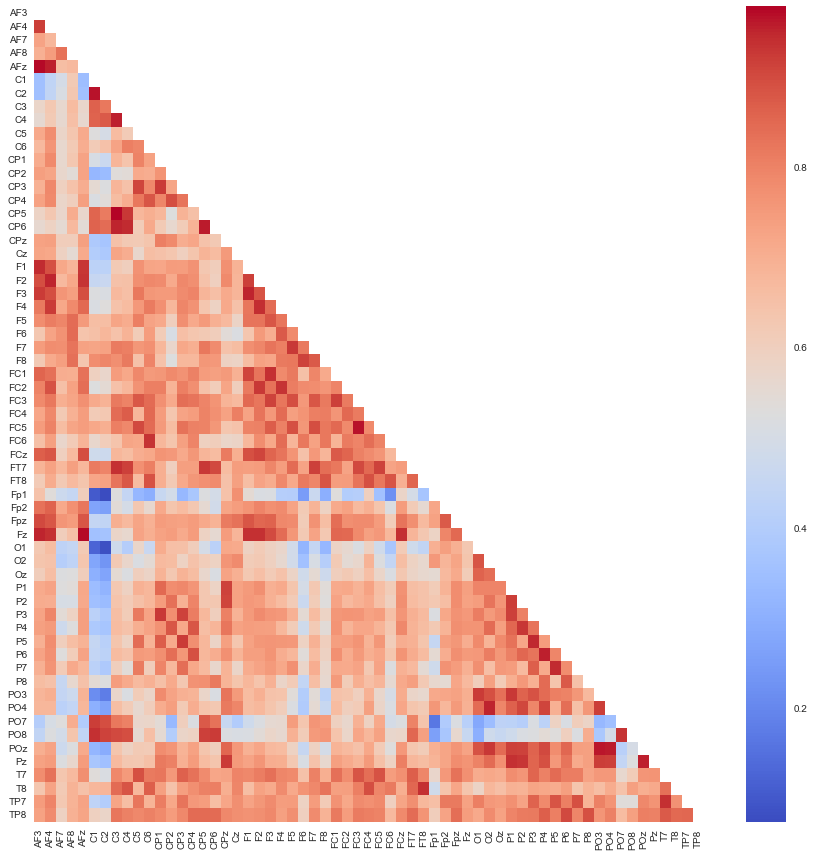

In [203]:
fig, ax = plt.subplots(figsize=(15,15))

mask = np.triu(np.ones_like(alcoholic.iloc[:, 4:].corr()))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(alcoholic.iloc[:, 4:].corr(), mask=mask, ax=ax, cmap='coolwarm')

<AxesSubplot:>

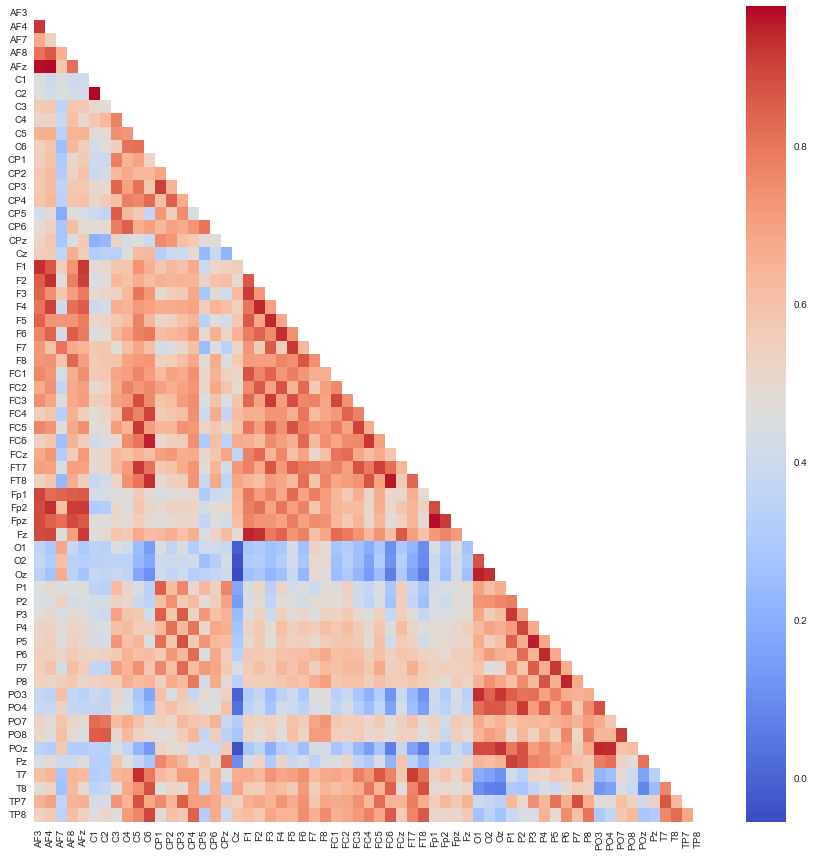

In [204]:
fig, ax = plt.subplots(figsize=(15,15))

mask = np.triu(np.ones_like(non_alcoholic.iloc[:, 4:].corr()))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(non_alcoholic.iloc[:, 4:].corr(), mask=mask, ax=ax, cmap='coolwarm')

The above two correlation heatmaps indicate significant changes in correlation factors between the frontla and the occipital lobes of the brain

In [205]:
df_fi

,name,trial_number,matching_condition,subject_identifier,AF3,AF4,AF7,AF8,AFz,C1,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
0,co2a0000364,0,S1 obj,a,1.700692,1.739463,1.822511,1.795006,1.633387,2.051294,...,1.542152,1.590766,1.974448,2.015901,1.584252,1.608417,1.780816,1.795275,1.758620,1.788958
1,co2a0000364,18,S1 obj,a,1.659566,1.723096,1.705376,1.761164,1.692712,1.993264,...,1.533984,1.564227,1.982388,1.992383,1.550257,1.506404,1.776409,1.793804,1.742791,1.751168
2,co2a0000369,13,"S2 nomatch,",a,1.271310,1.272597,1.289628,1.311693,1.265110,1.349457,...,1.349561,1.374062,1.425593,1.419841,1.322118,1.276568,1.227372,1.276205,1.255662,1.314677
3,co2a0000369,14,S1 obj,a,1.166186,1.172278,1.163713,1.196425,1.168838,1.273790,...,1.259396,1.276521,1.302407,1.288965,1.253587,1.232715,1.168394,1.181987,1.182166,1.199095
4,co2a0000369,15,"S2 nomatch,",a,1.235163,1.213154,1.262784,1.212771,1.220974,1.461236,...,1.453645,1.392232,1.579920,1.437338,1.409096,1.276344,1.335848,1.191168,1.402569,1.244633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,co2a0000369,8,S1 obj,a,1.279099,1.293361,1.316108,1.356561,1.282920,1.372748,...,1.373620,1.411618,1.421414,1.522489,1.371753,1.281114,1.282487,1.326395,1.301274,1.393879
464,co2a0000369,9,S2 match,a,1.286122,1.279556,1.337790,1.308418,1.276134,1.268850,...,1.270364,1.284434,1.380018,1.367391,1.252488,1.219911,1.260870,1.313869,1.260100,1.276796
465,co2a0000369,10,S1 obj,a,1.109113,1.101013,1.131772,1.099512,1.098954,1.198683,...,1.210699,1.223384,1.220514,1.206650,1.216914,1.289166,1.106610,1.101813,1.124591,1.122525
466,co2a0000369,11,S2 match,a,1.373803,1.372355,1.344014,1.442686,1.365313,1.289909,...,1.316285,1.336790,1.433559,1.400983,1.320162,1.290507,1.217283,1.379829,1.216651,1.338127


<h2>Machine Learning</h2>

In [206]:
df_fi['subject_identifier'] = df_fi['subject_identifier'].apply(lambda x: 1 if (x == 'a') else 0)

In [207]:
df_fi['subject_identifier'].value_counts()

1    235
0    233
Name: subject_identifier, dtype: int64

In [208]:
X = df_fi.iloc[:, 4:]
Y = df_fi['subject_identifier']

In [209]:
X = X.fillna(0)

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)
log_reg = LogisticRegression(solver = 'lbfgs', max_iter = 1000000)

In [211]:
X_train

,AF3,AF4,AF7,AF8,AFz,C1,C2,C3,C4,C5,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
148,1.431149,1.449699,1.455314,1.508366,1.437243,1.404416,1.487790,1.460079,1.577520,1.482765,...,1.435743,1.477500,1.421447,1.479931,1.444528,1.435441,1.563891,1.479159,1.467216,1.507651
131,1.582258,1.620607,1.532975,1.598068,1.596009,1.534326,1.432174,1.629243,1.612735,1.731339,...,1.570622,1.564935,1.585730,1.570030,1.542321,1.571207,1.725483,1.613471,1.645780,1.643934
437,1.459663,1.500592,1.679097,1.700154,1.452911,2.033340,2.025328,1.958876,2.003009,1.492658,...,1.430779,1.450728,1.934439,1.901397,1.441937,1.468417,1.478168,1.731286,1.486803,1.471335
317,1.490334,1.362715,1.721878,1.449596,1.410751,1.977104,2.021789,1.464252,1.601805,1.302661,...,1.514752,1.500947,1.866434,1.950600,1.534627,1.437068,1.314807,1.368341,1.334559,1.397718
400,1.384034,1.363232,1.670378,1.721630,1.359392,1.876584,1.940369,1.765965,1.765967,1.381895,...,1.298682,1.314744,1.867562,1.801926,1.312657,1.337665,1.399730,1.431522,1.423101,1.555701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,1.376832,1.338229,1.229469,1.348012,1.335025,1.965324,1.970720,1.396012,1.471518,1.262380,...,1.301238,1.327336,1.633077,1.662125,1.305143,1.263198,1.258909,1.411932,1.284319,1.371390
98,1.385847,1.319442,1.607721,1.529640,1.319580,1.396476,1.326403,1.412866,1.403186,1.432787,...,1.394460,1.390875,1.480560,1.448726,1.378472,1.379922,1.418146,1.300375,1.500361,1.353694
322,1.258539,1.270128,1.237339,1.485331,1.268763,1.953424,1.933056,1.910590,1.840243,1.626275,...,1.333372,1.335057,1.877852,1.798089,1.318736,1.340491,1.513891,1.471936,1.501494,1.542121
382,1.281257,1.286172,1.283854,1.306189,1.269235,1.344140,1.392098,1.329914,1.350185,1.305132,...,1.296240,1.317250,1.299797,1.355275,1.326672,1.284387,1.286719,1.404320,1.263974,1.405341


In [212]:
np.mean(X_train.isnull().mean())

0.0

<h2>Logistic Regression: Getting 86% Accuracy</h2>

In [213]:
log_reg.fit(X_train, y_train)
y_predicted = log_reg.predict(X_test)
print(accuracy_score(y_test,y_predicted))

0.8617021276595744


<h2>Naive Bayes Classifier: Getting 85% Accuracy</h2>

In [214]:
MNB = MultinomialNB()
MNB.fit(X_train, y_train)
predicted = MNB.predict(X_test)
print(accuracy_score(y_test, predicted))

0.851063829787234


<h2>Random Forest Classifier: 94.6%</h2>

In [215]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9468085106382979


In [216]:
importances = clf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

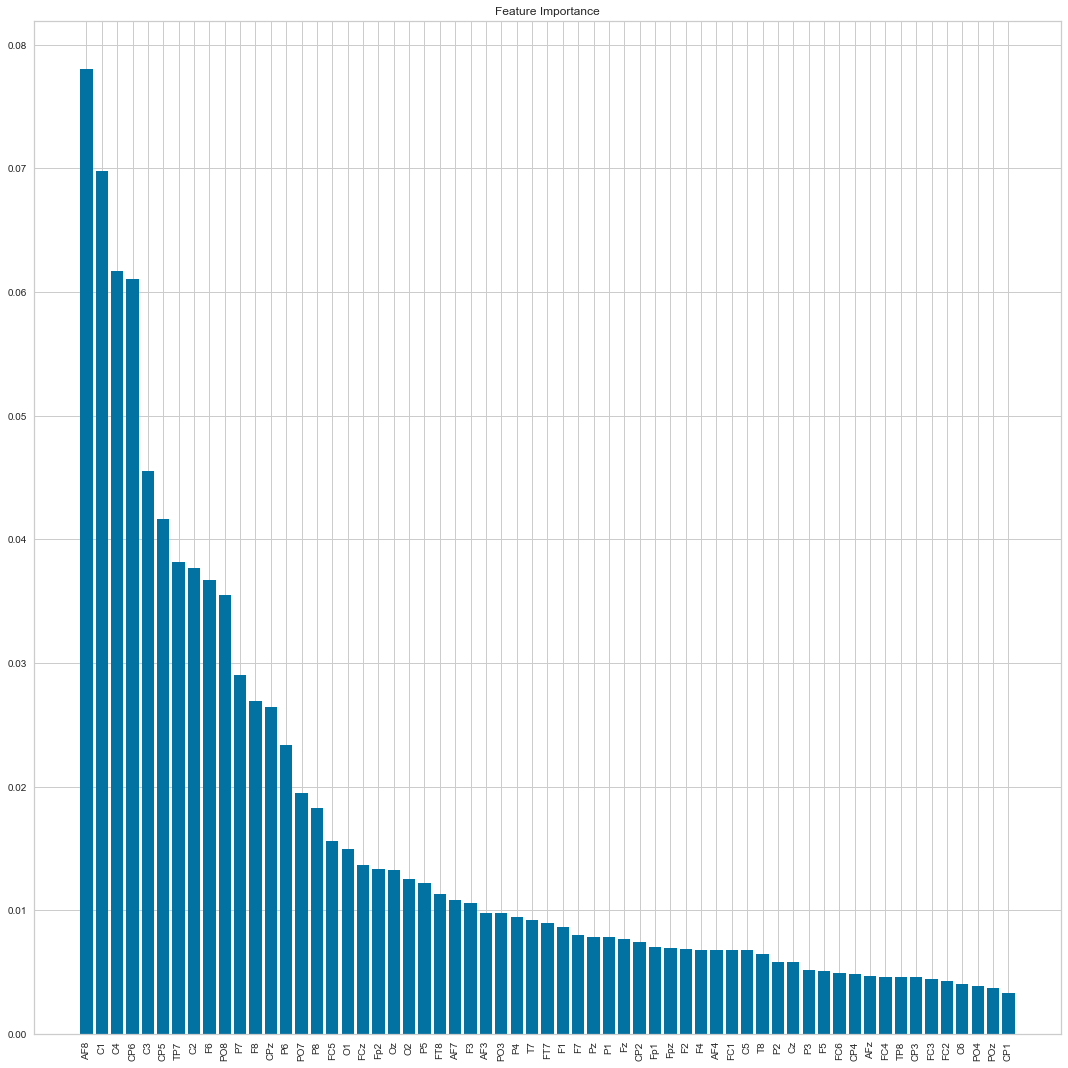

In [217]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

<h2>Pycaret</h2>

In [218]:
from pycaret.classification import *

In [219]:
df_fi

,name,trial_number,matching_condition,subject_identifier,AF3,AF4,AF7,AF8,AFz,C1,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
0,co2a0000364,0,S1 obj,1,1.700692,1.739463,1.822511,1.795006,1.633387,2.051294,...,1.542152,1.590766,1.974448,2.015901,1.584252,1.608417,1.780816,1.795275,1.758620,1.788958
1,co2a0000364,18,S1 obj,1,1.659566,1.723096,1.705376,1.761164,1.692712,1.993264,...,1.533984,1.564227,1.982388,1.992383,1.550257,1.506404,1.776409,1.793804,1.742791,1.751168
2,co2a0000369,13,"S2 nomatch,",1,1.271310,1.272597,1.289628,1.311693,1.265110,1.349457,...,1.349561,1.374062,1.425593,1.419841,1.322118,1.276568,1.227372,1.276205,1.255662,1.314677
3,co2a0000369,14,S1 obj,1,1.166186,1.172278,1.163713,1.196425,1.168838,1.273790,...,1.259396,1.276521,1.302407,1.288965,1.253587,1.232715,1.168394,1.181987,1.182166,1.199095
4,co2a0000369,15,"S2 nomatch,",1,1.235163,1.213154,1.262784,1.212771,1.220974,1.461236,...,1.453645,1.392232,1.579920,1.437338,1.409096,1.276344,1.335848,1.191168,1.402569,1.244633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,co2a0000369,8,S1 obj,1,1.279099,1.293361,1.316108,1.356561,1.282920,1.372748,...,1.373620,1.411618,1.421414,1.522489,1.371753,1.281114,1.282487,1.326395,1.301274,1.393879
464,co2a0000369,9,S2 match,1,1.286122,1.279556,1.337790,1.308418,1.276134,1.268850,...,1.270364,1.284434,1.380018,1.367391,1.252488,1.219911,1.260870,1.313869,1.260100,1.276796
465,co2a0000369,10,S1 obj,1,1.109113,1.101013,1.131772,1.099512,1.098954,1.198683,...,1.210699,1.223384,1.220514,1.206650,1.216914,1.289166,1.106610,1.101813,1.124591,1.122525
466,co2a0000369,11,S2 match,1,1.373803,1.372355,1.344014,1.442686,1.365313,1.289909,...,1.316285,1.336790,1.433559,1.400983,1.320162,1.290507,1.217283,1.379829,1.216651,1.338127


In [220]:
for col in df_fi.columns:
    if df_fi[col].isnull().sum() != 0:
        print(col)

Cz
O2


In [221]:
df_fi.iloc[:,3:]

,subject_identifier,AF3,AF4,AF7,AF8,AFz,C1,C2,C3,C4,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
0,1,1.700692,1.739463,1.822511,1.795006,1.633387,2.051294,2.037546,2.045791,2.044599,...,1.542152,1.590766,1.974448,2.015901,1.584252,1.608417,1.780816,1.795275,1.758620,1.788958
1,1,1.659566,1.723096,1.705376,1.761164,1.692712,1.993264,2.019853,1.976447,2.013922,...,1.533984,1.564227,1.982388,1.992383,1.550257,1.506404,1.776409,1.793804,1.742791,1.751168
2,1,1.271310,1.272597,1.289628,1.311693,1.265110,1.349457,1.309059,1.364328,1.321455,...,1.349561,1.374062,1.425593,1.419841,1.322118,1.276568,1.227372,1.276205,1.255662,1.314677
3,1,1.166186,1.172278,1.163713,1.196425,1.168838,1.273790,1.230394,1.209092,1.210653,...,1.259396,1.276521,1.302407,1.288965,1.253587,1.232715,1.168394,1.181987,1.182166,1.199095
4,1,1.235163,1.213154,1.262784,1.212771,1.220974,1.461236,1.190859,1.413557,1.201693,...,1.453645,1.392232,1.579920,1.437338,1.409096,1.276344,1.335848,1.191168,1.402569,1.244633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,1,1.279099,1.293361,1.316108,1.356561,1.282920,1.372748,1.372421,1.354135,1.446386,...,1.373620,1.411618,1.421414,1.522489,1.371753,1.281114,1.282487,1.326395,1.301274,1.393879
464,1,1.286122,1.279556,1.337790,1.308418,1.276134,1.268850,1.372797,1.232581,1.338069,...,1.270364,1.284434,1.380018,1.367391,1.252488,1.219911,1.260870,1.313869,1.260100,1.276796
465,1,1.109113,1.101013,1.131772,1.099512,1.098954,1.198683,1.183486,1.160105,1.165196,...,1.210699,1.223384,1.220514,1.206650,1.216914,1.289166,1.106610,1.101813,1.124591,1.122525
466,1,1.373803,1.372355,1.344014,1.442686,1.365313,1.289909,1.405752,1.261413,1.414307,...,1.316285,1.336790,1.433559,1.400983,1.320162,1.290507,1.217283,1.379829,1.216651,1.338127


In [222]:
clf = setup(data=pd.concat([X_train, y_train], axis=1), target='subject_identifier', normalize=True)

,Description,Value
0,session_id,4066
1,Target,subject_identifier
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(374, 62)"
5,Missing Values,False
6,Numeric Features,61
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [226]:
compare_models(fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.9692,0.9842,0.9606,0.9759,0.9680,0.9383,0.9389,0.0060
et,Extra Trees Classifier,0.9578,0.9923,0.9372,0.9775,0.9558,0.9154,0.9179,0.0680
ridge,Ridge Classifier,0.9540,0.0000,0.9526,0.9540,0.9523,0.9078,0.9096,0.0060
rf,Random Forest Classifier,0.9501,0.9916,0.9455,0.9538,0.9495,0.9001,0.9005,0.0880
lda,Linear Discriminant Analysis,0.9463,0.9815,0.9372,0.9530,0.9444,0.8924,0.8938,0.0060
lightgbm,Light Gradient Boosting Machine,0.9387,0.9835,0.9228,0.9545,0.9362,0.8774,0.8816,0.0180
lr,Logistic Regression,0.9311,0.9836,0.9295,0.9337,0.9296,0.8620,0.8657,0.0080
xgboost,Extreme Gradient Boosting,0.9311,0.9842,0.9382,0.9252,0.9307,0.8622,0.8639,0.0340
gbc,Gradient Boosting Classifier,0.9274,0.9774,0.9071,0.9461,0.9251,0.8547,0.8572,0.0660
ada,Ada Boost Classifier,0.9233,0.9561,0.9145,0.9306,0.9214,0.8465,0.8485,0.0380


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [225]:
hig_qda = create_model('qda', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.9808,1.0000,0.9615,1.0000,0.9804,0.9615,0.9623
2,0.9808,0.9985,0.9615,1.0000,0.9804,0.9615,0.9623
3,0.9808,0.9778,1.0000,0.9630,0.9811,0.9615,0.9623
4,0.9038,0.9444,0.8800,0.9167,0.8980,0.8071,0.8077
Mean,0.9692,0.9842,0.9606,0.9759,0.9680,0.9383,0.9389
Std,0.0335,0.0216,0.0438,0.0329,0.0358,0.0673,0.0672


In [250]:
hig_et = create_model('et', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9623,0.9964,0.9615,0.9615,0.9615,0.9245,0.9245
1,0.9808,0.9941,0.9615,1.0000,0.9804,0.9615,0.9623
2,0.9808,1.0000,0.9615,1.0000,0.9804,0.9615,0.9623
3,0.9423,0.9793,0.9615,0.9259,0.9434,0.8846,0.8853
4,0.9231,0.9919,0.8400,1.0000,0.9130,0.8450,0.8553
Mean,0.9578,0.9923,0.9372,0.9775,0.9558,0.9154,0.9179
Std,0.0225,0.0071,0.0486,0.0298,0.0254,0.0453,0.0423


In [251]:
hig_tuned_et = tune_model(hig_et, fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9623,0.9943,0.9231,1.0000,0.9600,0.9244,0.9270
1,0.9038,0.9749,0.8846,0.9200,0.9020,0.8077,0.8083
2,0.9231,0.9970,0.8462,1.0000,0.9167,0.8462,0.8563
3,0.9038,0.9660,0.9231,0.8889,0.9057,0.8077,0.8083
4,0.8846,0.9689,0.7600,1.0000,0.8636,0.7668,0.7886
Mean,0.9155,0.9802,0.8674,0.9618,0.9096,0.8305,0.8377
Std,0.0263,0.0130,0.0608,0.0478,0.0309,0.0532,0.0500


In [253]:
hig_et

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=4066, verbose=0,
                     warm_start=False)

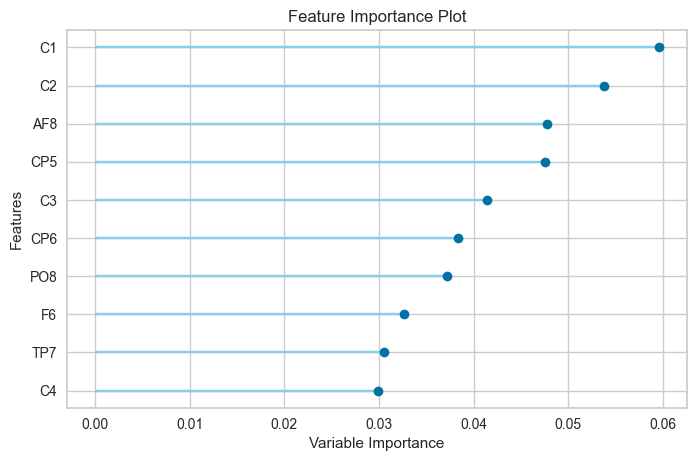

In [254]:
plot_model(hig_et, plot='feature')

C1, C2 have the highest feature importance, indicating that these two EEG channels played the most significant role in differentiating between alcoholics and non alcoholics

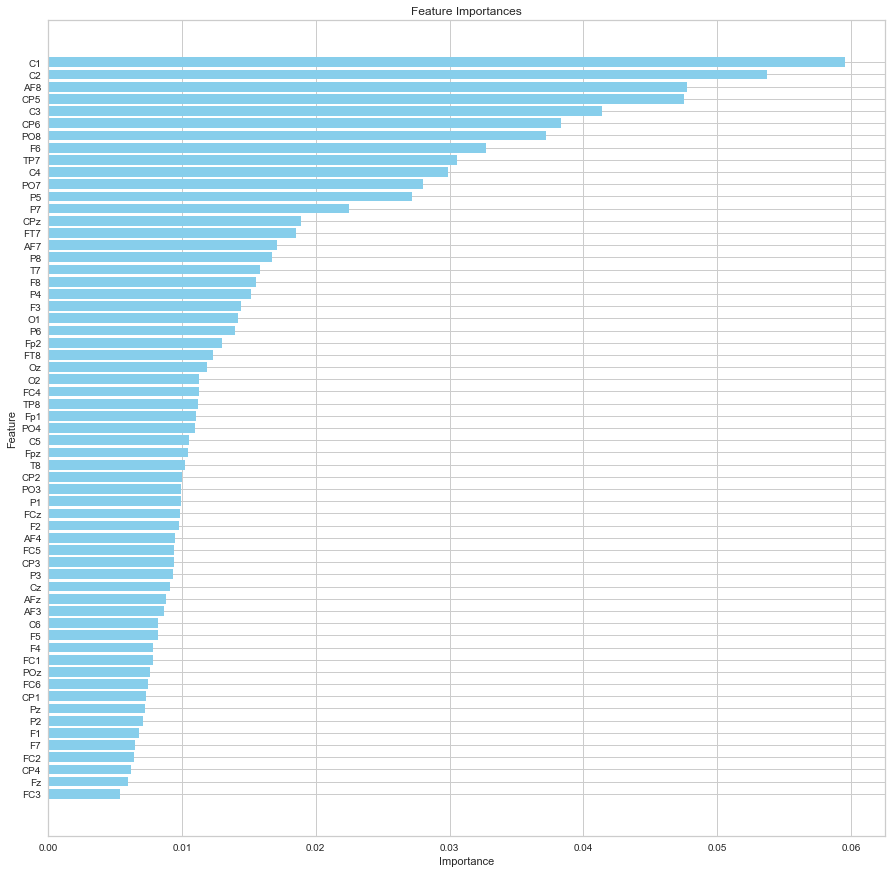

In [265]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = hig_et.feature_importances_

# Create a DataFrame to hold feature names and their importance values
importances_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

# Sort the DataFrame by importance in descending order
importances_df = importances_df.sort_values('importance', ascending=True)

# Plot
plt.figure(figsize=(15, 15))  # Adjust as needed
plt.barh(importances_df['feature'], importances_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()


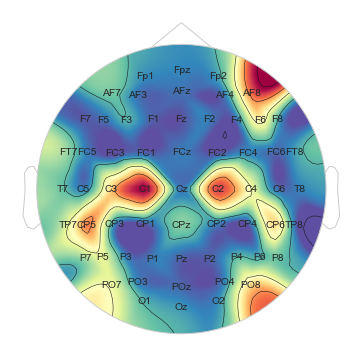

(<matplotlib.image.AxesImage at 0x1eb4c159550>,
 <matplotlib.contour.QuadContourSet at 0x1eb4c1598b0>)

In [269]:
# Plotting Topographic plot of the feature importances
from matplotlib.colors import TwoSlopeNorm
plt.rcParams.update({'font.size': 15})  # or whatever size you want
cnorm = TwoSlopeNorm(vmin=min(importances), vcenter=(min(importances) + max(importances))/2, vmax=max(importances))
mne.viz.plot_topomap(data=importances, pos=raw.info, names=X_train.columns, show_names=True, cnorm=cnorm, cmap='Spectral_r')

The topo plot indicates midbrain region, occipital region and AF8 region of the brain as having higher feature importances. This may imply that the impact of alcohol is the highest in these regions based on the classification model.

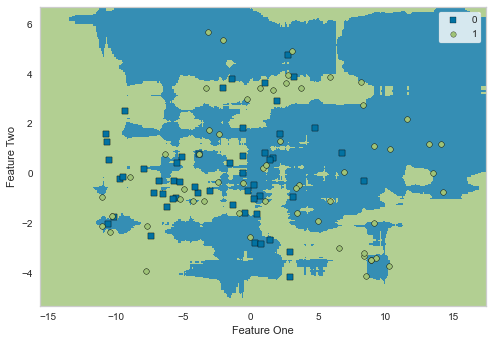

In [260]:
plot_model(hig_et, plot='boundary')


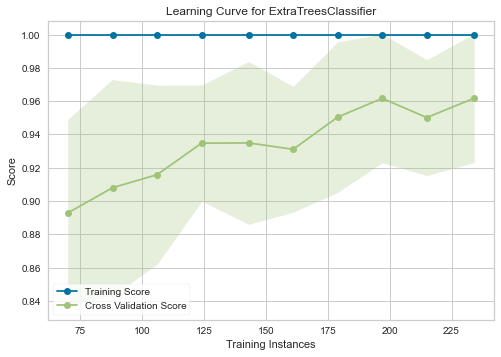

In [261]:
plot_model(hig_et, plot='learning')


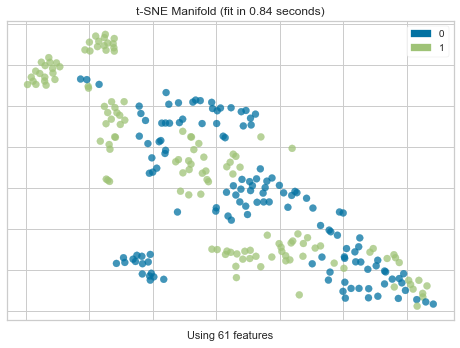

In [263]:
plot_model(hig_et, plot='manifold')

In [229]:
predictions = predict_model(hig_qda, data=pd.concat([X_test, y_test], axis=1))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Quadratic Discriminant Analysis,0.9894,1.0000,0.9787,1.0000,0.9892,0.9787,0.9789


In [230]:
predictions

,AF3,AF4,AF7,AF8,AFz,C1,C2,C3,C4,C5,...,PO8,POz,Pz,T7,T8,TP7,TP8,subject_identifier,Label,Score
48,1.359065,1.436667,1.671254,1.616046,1.358226,1.410298,1.378298,1.390135,1.307464,1.398655,...,1.445341,1.413955,1.396389,1.322666,1.355560,1.454947,1.326851,1,1,1.0000
355,1.309557,1.322043,1.436861,1.448252,1.287923,1.469967,1.283455,1.522870,1.367283,1.425860,...,1.369989,1.419409,1.415680,1.410847,1.429562,1.416947,1.325083,0,0,1.0000
85,1.449702,1.497161,1.524697,1.587027,1.462336,1.640263,1.607927,1.951000,1.901484,1.465194,...,1.640386,1.585117,1.620701,1.537624,1.647761,1.651216,1.554333,1,1,1.0000
34,1.586595,1.746306,1.810999,1.821164,1.595003,2.053240,2.033559,2.048646,2.008049,1.835569,...,1.947196,1.534651,1.523829,1.802659,1.776128,1.758321,1.791383,1,1,1.0000
11,1.274112,1.274333,1.333325,1.321523,1.274659,1.399733,1.347401,1.352229,1.367181,1.345313,...,1.282674,1.193047,1.178507,1.311296,1.301874,1.328229,1.250880,1,1,0.9979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,1.546020,1.650127,1.630083,1.725846,1.551780,2.032144,1.994448,1.948876,1.975176,1.735532,...,1.910151,1.648125,1.600274,1.706240,1.864051,1.664938,1.804135,1,1,1.0000
419,1.464053,1.384610,1.667800,1.725632,1.411986,1.894448,1.896834,1.757425,1.699722,1.480074,...,1.850421,1.351736,1.333363,1.411492,1.408012,1.410648,1.514922,1,1,1.0000
336,1.359384,1.303632,1.652655,1.311256,1.289434,1.976082,1.978296,1.520764,1.592296,1.329856,...,1.935241,1.621977,1.499794,1.308643,1.444953,1.371058,1.375549,0,0,1.0000
414,1.724364,1.670810,1.727092,1.781789,1.705669,1.868731,1.890356,1.741894,1.715081,1.538322,...,1.847639,1.464021,1.475696,1.480381,1.404601,1.503088,1.487805,1,1,1.0000


In [247]:
# import classification report and confusion matrix from sklearn library
from sklearn.metrics import classification_report, confusion_matrix

# create a function to plot confusion matrix and classification report
def plot_cm_cr(model):
    # create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    # plot confusion matrix on 1st subplot
    sns.heatmap(confusion_matrix(predictions['subject_identifier'], predictions['Label']), annot=True, fmt='d', ax=ax[0])
    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('Predicted Label')
    ax[0].set_ylabel('True Label')
    
    # plot classification report on 2nd subplot
    sns.heatmap(pd.DataFrame(classification_report(predictions['subject_identifier'], predictions['Label'], output_dict=True)).iloc[:-1, :].T, annot=True, ax=ax[1])
    ax[1].set_title('Classification Report')
    ax[1].set_xlabel('Metrics')
    ax[1].set_ylabel('Classes')

    print(classification_report(predictions['subject_identifier'], predictions['Label']))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        47
           1       1.00      0.98      0.99        47

    accuracy                           0.99        94
   macro avg       0.99      0.99      0.99        94
weighted avg       0.99      0.99      0.99        94



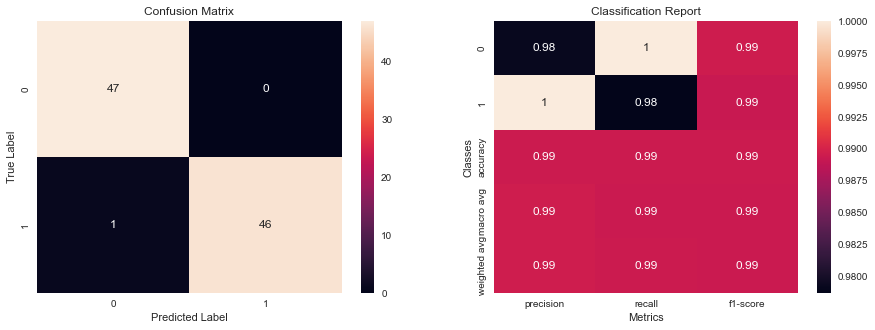

In [248]:
plot_cm_cr(hig_qda)

High metric scores indicate overfitting. Data is also very less which is not ideal

<h1>2. Katz</h1>

In [271]:
df_katz = pd.DataFrame(katz_dict)
df_katz

,name,trial_number,matching_condition,subject_identifier,AF3,AF4,AF7,AF8,AFz,C1,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
0,co2a0000364,0,S1 obj,a,2.333333,2.730060,2.604346,2.734255,2.324854,4.258159,...,1.975576,2.055116,4.031731,3.952125,2.043466,2.163168,2.766509,2.940140,2.413973,3.354376
1,co2a0000364,18,S1 obj,a,2.201511,2.624427,2.386730,2.996668,2.435463,3.479748,...,2.411733,2.204339,4.884100,4.663311,2.295877,2.147428,2.429630,3.044131,2.589302,2.506729
2,co2a0000369,13,"S2 nomatch,",a,1.898549,1.831930,2.040173,1.838732,1.816930,1.996885,...,2.207290,1.822900,2.199518,2.050307,2.167773,2.431059,2.111523,2.258549,2.082019,2.343313
3,co2a0000369,14,S1 obj,a,2.008931,2.009143,1.919014,2.109247,1.995924,2.462828,...,1.968613,2.189831,1.996584,2.184228,2.049717,2.010650,2.034801,2.069369,1.970201,2.035330
4,co2a0000369,15,"S2 nomatch,",a,2.044478,2.007856,2.009403,1.899903,1.986822,1.955729,...,1.905788,1.866921,2.210600,1.864348,1.808289,1.716689,1.894482,1.880957,2.033145,1.958245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,co2a0000369,8,S1 obj,a,2.226696,2.259958,2.216257,2.039874,2.191584,2.005557,...,1.892983,1.867991,2.006756,1.964871,1.939390,1.797179,1.936930,1.859005,2.013998,1.987339
464,co2a0000369,9,S2 match,a,1.600697,1.565045,1.602761,1.549581,1.600680,1.667986,...,1.751776,1.847785,1.774189,1.815198,1.819699,2.053146,1.526278,1.622739,1.570191,1.658470
465,co2a0000369,10,S1 obj,a,2.109430,2.093006,2.186000,2.032200,2.104307,2.040338,...,2.066092,1.980474,2.092321,1.955832,2.064903,2.132239,1.992495,1.794088,2.047717,1.795672
466,co2a0000369,11,S2 match,a,2.111299,2.007817,1.888916,1.961346,2.112176,1.990169,...,2.014589,1.937748,2.252017,2.007376,1.921324,2.157398,1.872322,1.940419,1.926885,1.932724


In [272]:
alcoholic = df_katz[df_katz['subject_identifier'] == 'a']
alcoholic

,name,trial_number,matching_condition,subject_identifier,AF3,AF4,AF7,AF8,AFz,C1,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
0,co2a0000364,0,S1 obj,a,2.333333,2.730060,2.604346,2.734255,2.324854,4.258159,...,1.975576,2.055116,4.031731,3.952125,2.043466,2.163168,2.766509,2.940140,2.413973,3.354376
1,co2a0000364,18,S1 obj,a,2.201511,2.624427,2.386730,2.996668,2.435463,3.479748,...,2.411733,2.204339,4.884100,4.663311,2.295877,2.147428,2.429630,3.044131,2.589302,2.506729
2,co2a0000369,13,"S2 nomatch,",a,1.898549,1.831930,2.040173,1.838732,1.816930,1.996885,...,2.207290,1.822900,2.199518,2.050307,2.167773,2.431059,2.111523,2.258549,2.082019,2.343313
3,co2a0000369,14,S1 obj,a,2.008931,2.009143,1.919014,2.109247,1.995924,2.462828,...,1.968613,2.189831,1.996584,2.184228,2.049717,2.010650,2.034801,2.069369,1.970201,2.035330
4,co2a0000369,15,"S2 nomatch,",a,2.044478,2.007856,2.009403,1.899903,1.986822,1.955729,...,1.905788,1.866921,2.210600,1.864348,1.808289,1.716689,1.894482,1.880957,2.033145,1.958245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,co2a0000369,8,S1 obj,a,2.226696,2.259958,2.216257,2.039874,2.191584,2.005557,...,1.892983,1.867991,2.006756,1.964871,1.939390,1.797179,1.936930,1.859005,2.013998,1.987339
464,co2a0000369,9,S2 match,a,1.600697,1.565045,1.602761,1.549581,1.600680,1.667986,...,1.751776,1.847785,1.774189,1.815198,1.819699,2.053146,1.526278,1.622739,1.570191,1.658470
465,co2a0000369,10,S1 obj,a,2.109430,2.093006,2.186000,2.032200,2.104307,2.040338,...,2.066092,1.980474,2.092321,1.955832,2.064903,2.132239,1.992495,1.794088,2.047717,1.795672
466,co2a0000369,11,S2 match,a,2.111299,2.007817,1.888916,1.961346,2.112176,1.990169,...,2.014589,1.937748,2.252017,2.007376,1.921324,2.157398,1.872322,1.940419,1.926885,1.932724


In [273]:
non_alcoholic = df_katz[df_katz['subject_identifier'] == 'c']
non_alcoholic

,name,trial_number,matching_condition,subject_identifier,AF3,AF4,AF7,AF8,AFz,C1,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
152,co2c0000337,0,S1 obj,c,2.349214,2.157828,2.042965,2.105132,1.813923,2.610573,...,2.109860,1.989084,3.601315,2.758497,2.112188,1.901256,2.227698,2.586356,1.987900,2.192165
153,co2c0000337,2,S1 obj,c,2.315444,2.283276,2.535454,2.203298,2.043438,2.513045,...,2.074489,1.917470,3.177035,3.512037,2.135147,1.903957,2.274574,3.319814,2.078083,2.693942
154,co2c0000337,16,S1 obj,c,2.229336,2.316815,2.492767,2.686047,2.175638,6.509548,...,2.088328,2.173289,3.770679,3.459038,2.115913,2.073031,2.276843,2.870609,2.150007,2.297351
155,co2c0000337,17,S2 match,c,1.329814,1.273233,1.383388,1.301341,1.313616,4.394551,...,1.526083,1.494271,2.580671,2.347275,1.548250,1.564766,1.939674,2.916984,1.601380,2.214581
157,co2c0000337,21,"S2 nomatch,",c,1.471272,1.413583,1.484815,1.375409,1.455082,4.176704,...,1.704149,1.744272,3.824520,3.071734,1.655371,1.778159,2.139154,2.456148,1.761157,2.270613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,co2c0000345,31,"S2 nomatch,",c,2.117748,1.957727,1.998338,1.834874,2.004341,2.180477,...,2.127509,2.164358,2.197252,2.127351,1.959053,2.074867,2.108943,1.847756,2.003107,2.024801
406,co2c0000345,33,"S2 nomatch,",c,2.040126,1.969503,2.085377,2.225963,1.932328,2.141712,...,1.895979,1.854166,1.916043,1.759538,1.862511,1.852387,2.211275,1.891745,1.863236,1.839681
407,co2c0000345,37,S2 match,c,1.832155,1.775871,1.737986,1.630031,1.837938,2.328196,...,1.950703,1.920659,1.775077,2.127791,2.016980,1.891880,2.160905,1.866755,1.862592,2.017638
408,co2c0000345,41,S2 match,c,1.754915,1.684617,1.872868,1.742966,1.698204,1.650903,...,1.995513,2.234377,2.035276,2.137969,2.002431,2.053595,1.889293,1.781328,1.909333,2.130777


<AxesSubplot:>

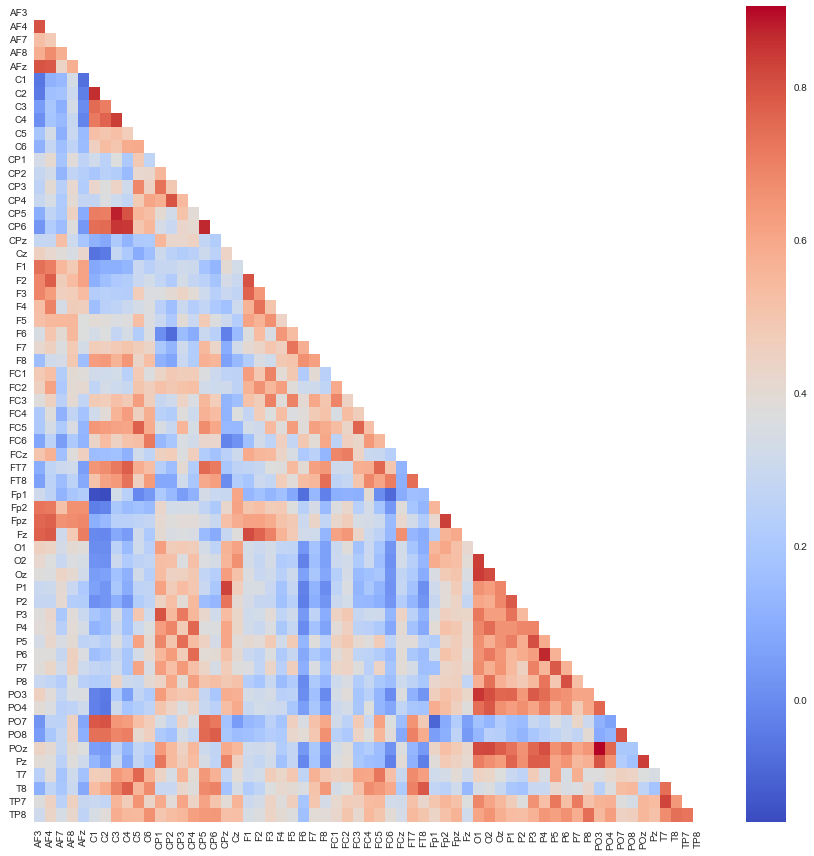

In [274]:
fig, ax = plt.subplots(figsize=(15,15))

mask = np.triu(np.ones_like(alcoholic.iloc[:, 4:].corr()))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(alcoholic.iloc[:, 4:].corr(), mask=mask, ax=ax, cmap='coolwarm')

<AxesSubplot:>

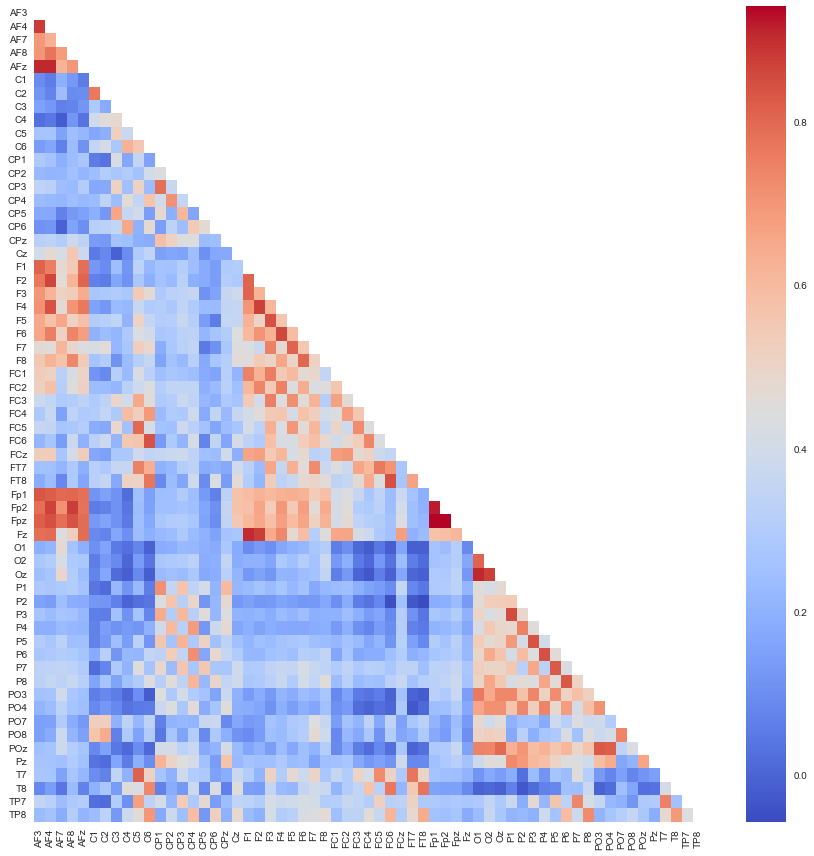

In [275]:
fig, ax = plt.subplots(figsize=(15,15))

mask = np.triu(np.ones_like(non_alcoholic.iloc[:, 4:].corr()))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(non_alcoholic.iloc[:, 4:].corr(), mask=mask, ax=ax, cmap='coolwarm')

<h2>Machine Learning</h2>

In [276]:
df_katz['subject_identifier'] = df_katz['subject_identifier'].apply(lambda x: 1 if (x == 'a') else 0)

In [277]:
df_katz['subject_identifier'].value_counts()

1    235
0    233
Name: subject_identifier, dtype: int64

In [278]:
X = df_katz.iloc[:, 4:]
Y = df_katz['subject_identifier']

In [279]:
X = X.fillna(0)

In [280]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)
log_reg = LogisticRegression(solver = 'lbfgs', max_iter = 1000000)

In [281]:
X_train

,AF3,AF4,AF7,AF8,AFz,C1,C2,C3,C4,C5,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
148,1.900390,2.041051,1.835740,1.850972,1.934115,1.740796,1.970299,2.054150,2.033478,2.452085,...,1.621414,1.613267,1.714841,1.600678,1.562818,1.551209,2.147451,1.672440,1.889798,1.625420
131,1.907283,1.983710,1.819299,1.960903,1.942318,1.941570,1.710980,1.909345,1.979525,1.941966,...,1.774616,1.667100,1.788125,1.690990,1.710958,1.804013,2.261507,1.777032,1.816571,1.718798
437,2.213035,1.949230,2.388643,2.321626,1.677537,2.585565,2.818875,2.549876,2.990656,1.682223,...,1.609085,1.676650,2.848669,2.949992,1.832116,1.606918,1.646737,2.212626,1.667369,1.688300
317,1.590127,1.509480,1.993069,1.674996,1.593110,3.678201,4.151338,1.757168,1.817524,1.437839,...,1.854493,2.065916,2.573306,4.148195,2.039125,2.129970,1.487969,1.471543,1.508462,1.557308
400,1.727203,1.799300,2.255233,2.300940,1.805342,3.338714,4.754887,3.090835,3.929105,1.910686,...,2.001405,1.539760,3.865304,2.921587,2.217801,2.086503,1.763790,2.265756,1.845052,2.187518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,1.646002,1.615040,1.446191,1.781100,1.594620,4.388687,2.900049,1.926215,1.976920,1.737161,...,1.689871,1.749439,2.152608,2.098859,1.747703,1.783519,1.811712,1.753372,1.769785,1.724347
98,2.227441,2.261604,2.065803,2.752970,2.238200,2.303101,2.320062,2.015199,1.997938,1.857596,...,1.999574,1.903262,1.981402,2.049901,2.129488,2.208823,1.727026,1.833242,1.798846,1.839656
322,1.366716,1.411458,1.311279,1.553785,1.416905,3.133320,3.398338,4.048106,3.742088,2.629508,...,1.666785,1.629926,3.081915,2.725235,1.666794,1.781410,2.261511,1.960287,1.894564,1.881731
382,1.812308,1.860997,1.743593,1.845178,1.807207,2.012742,2.143074,2.141051,1.989755,2.026248,...,2.105248,2.083006,2.081408,2.022761,2.085854,2.215344,2.034655,1.844110,1.875940,1.865779


In [282]:
np.mean(X_train.isnull().mean())

0.0

<h2>Logistic Regression: 85.10% Accuracy</h2>

In [283]:
log_reg.fit(X_train, y_train)
y_predicted = log_reg.predict(X_test)
print(accuracy_score(y_test,y_predicted))

0.851063829787234


<h2>Naive Bayes: 81.91%</h2>

In [284]:
MNB = MultinomialNB()
MNB.fit(X_train, y_train)
predicted = MNB.predict(X_test)
print(accuracy_score(y_test, predicted))

0.8191489361702128


<h2>Random Forest: 90.4%</h2>

In [285]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.851063829787234


In [286]:
importances = clf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

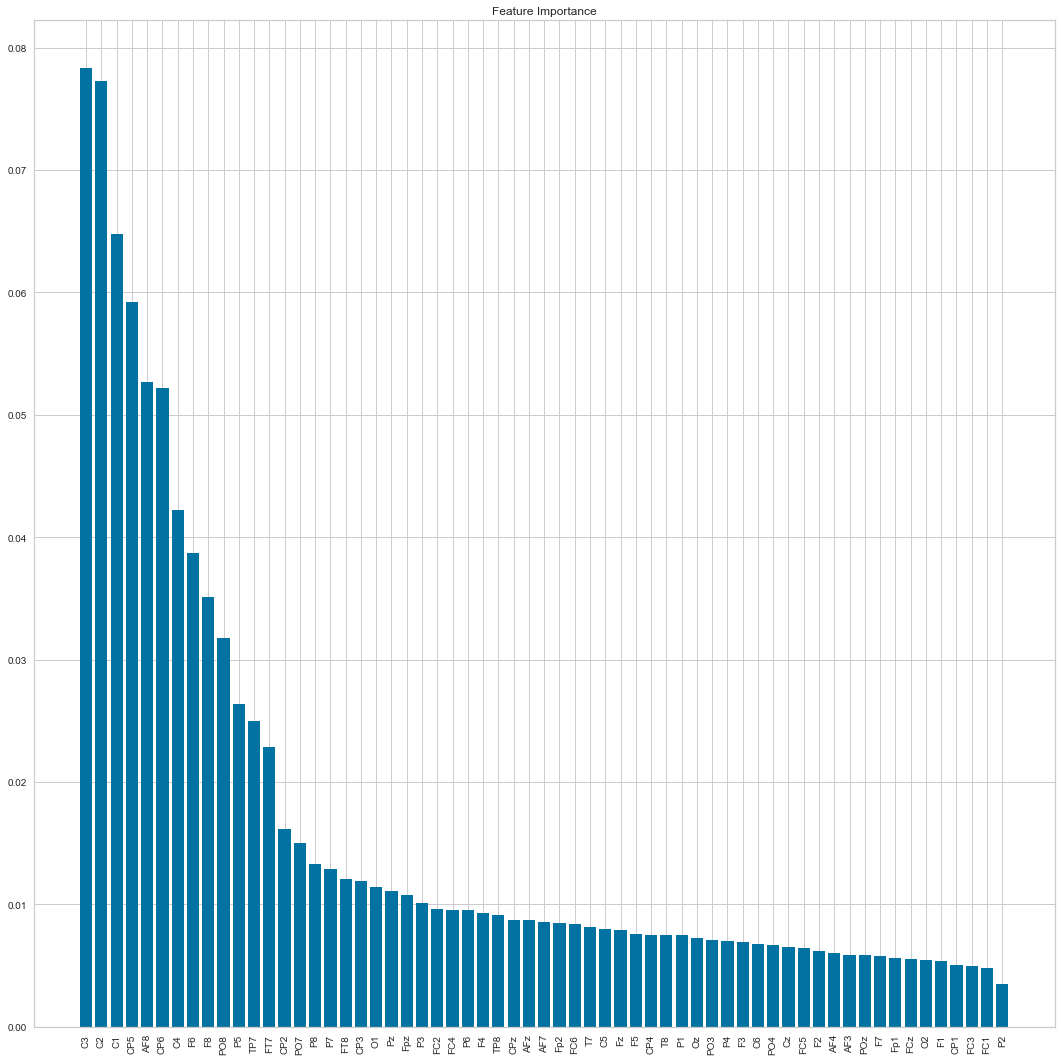

In [287]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

<h2>Pycaret</h2>

In [288]:
from pycaret.classification import *

In [289]:
for col in df_katz.columns:
    if df_katz[col].isnull().sum() != 0:
        print(col)

Cz
O2


In [291]:
clf = setup(data=df_katz.iloc[:,3:], target='subject_identifier', normalize=True)

,Description,Value
0,session_id,2432
1,Target,subject_identifier
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(468, 62)"
5,Missing Values,True
6,Numeric Features,61
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [87]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8991,0.9630,0.9154,0.8928,0.9016,0.7986,0.8031,0.0570
et,Extra Trees Classifier,0.8929,0.9641,0.9029,0.8923,0.8951,0.7860,0.7905,0.0540
lightgbm,Light Gradient Boosting Machine,0.8902,0.9597,0.8849,0.8988,0.8896,0.7808,0.7846,0.0210
gbc,Gradient Boosting Classifier,0.8842,0.9508,0.8908,0.8845,0.8856,0.7683,0.7719,0.0480
xgboost,Extreme Gradient Boosting,0.8777,0.9560,0.8963,0.8703,0.8803,0.7557,0.7612,0.0390
ridge,Ridge Classifier,0.8626,0.0000,0.8305,0.8907,0.8562,0.7256,0.7318,0.0050
lda,Linear Discriminant Analysis,0.8626,0.9461,0.8305,0.8915,0.8562,0.7257,0.7325,0.0050
lr,Logistic Regression,0.8566,0.9460,0.8419,0.8734,0.8543,0.7136,0.7183,0.0090
qda,Quadratic Discriminant Analysis,0.8443,0.9409,0.8176,0.8652,0.8391,0.6887,0.6919,0.0050
knn,K Neighbors Classifier,0.8259,0.9072,0.8787,0.7980,0.8344,0.6521,0.6595,0.0130


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=2295, verbose=0,
                       warm_start=False)

In [293]:
katz_rf = create_model('rf', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9091,0.9430,0.8750,0.9333,0.9032,0.8177,0.8192
1,0.9091,0.9844,0.9697,0.8649,0.9143,0.8182,0.8243
2,0.8923,0.9545,0.8438,0.9310,0.8852,0.7843,0.7876
3,0.7846,0.8764,0.7812,0.7812,0.7812,0.5691,0.5691
4,0.8923,0.9659,0.8438,0.9310,0.8852,0.7843,0.7876
Mean,0.8775,0.9449,0.8627,0.8883,0.8739,0.7547,0.7576
Std,0.0470,0.0368,0.0616,0.0595,0.0476,0.0940,0.0955


In [294]:
katz_tuned_rf = tune_model(katz_rf, fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9091,0.9522,0.8750,0.9333,0.9032,0.8177,0.8192
1,0.9545,0.9899,1.0000,0.9167,0.9565,0.9091,0.9129
2,0.8615,0.9460,0.7812,0.9259,0.8475,0.7224,0.7311
3,0.7846,0.8911,0.7812,0.7812,0.7812,0.5691,0.5691
4,0.8923,0.9602,0.8438,0.9310,0.8852,0.7843,0.7876
Mean,0.8804,0.9479,0.8562,0.8976,0.8747,0.7605,0.7640
Std,0.0566,0.0321,0.0805,0.0585,0.0585,0.1131,0.1139


Katz is giving suboptimal performance

In [411]:
katz_tuned_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=7, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.001, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=2432, verbose=0,
                       warm_start=False)

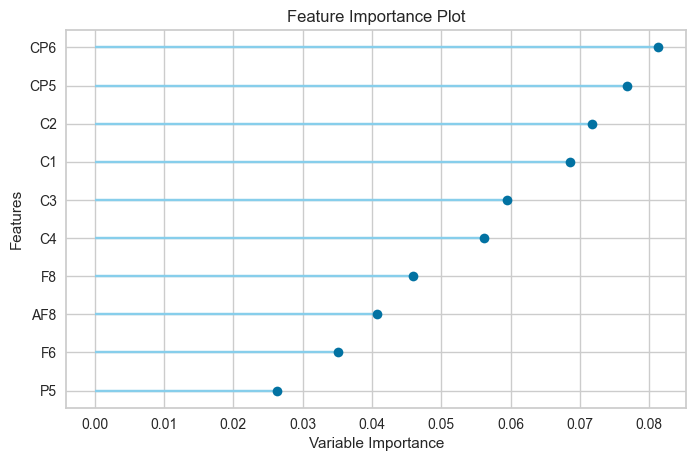

In [412]:
plot_model(katz_tuned_rf, plot='feature')

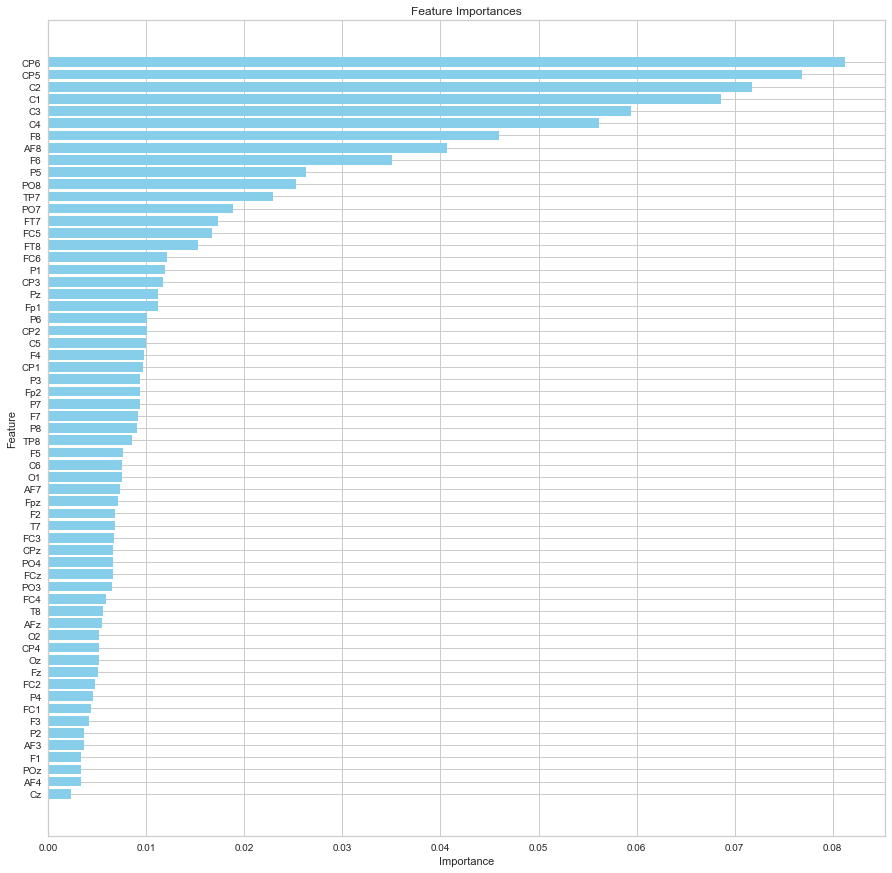

In [414]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = katz_tuned_rf.feature_importances_

# Create a DataFrame to hold feature names and their importance values
importances_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

# Sort the DataFrame by importance in descending order
importances_df = importances_df.sort_values('importance', ascending=True)

# Plot
plt.figure(figsize=(15, 15))  # Adjust as needed
plt.barh(importances_df['feature'], importances_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()


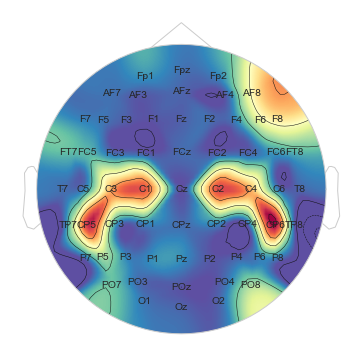

(<matplotlib.image.AxesImage at 0x1eb51ca5190>,
 <matplotlib.contour.QuadContourSet at 0x1eb51ca5460>)

In [415]:
from matplotlib.colors import TwoSlopeNorm
plt.rcParams.update({'font.size': 15})  # or whatever size you want
cnorm = TwoSlopeNorm(vmin=min(importances), vcenter=(min(importances) + max(importances))/2, vmax=max(importances))
mne.viz.plot_topomap(data=importances, pos=raw.info, names=X_train.columns, show_names=True, cnorm=cnorm, cmap='Spectral_r')

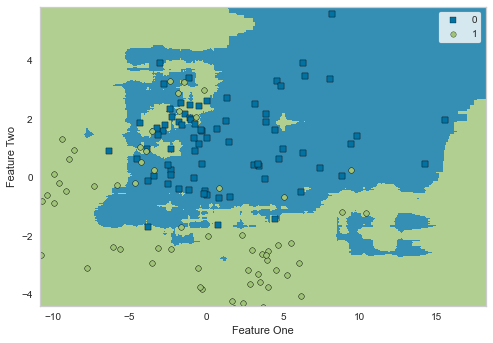

In [418]:
plot_model(hig_et, plot='boundary')


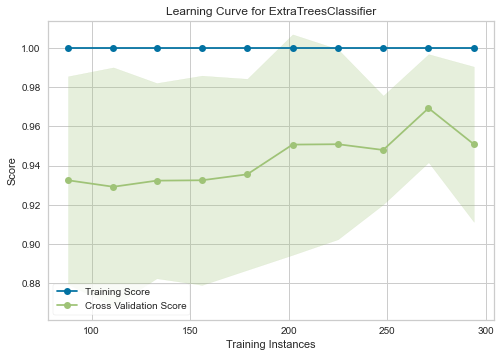

In [419]:
plot_model(hig_et, plot='learning')


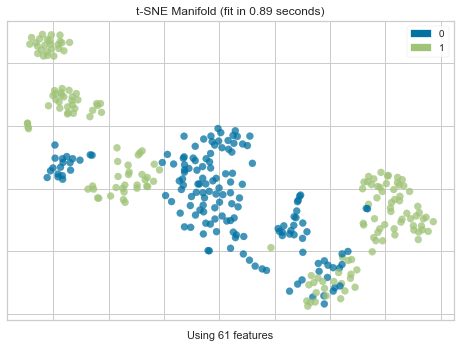

In [420]:
plot_model(hig_et, plot='manifold')

In [421]:
predictions = predict_model(hig_qda, data=pd.concat([X_test, y_test], axis=1))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Quadratic Discriminant Analysis,0.7872,0.8361,0.9574,0.7143,0.8182,0.5745,0.6110


In [422]:
predictions

,AF3,AF4,AF7,AF8,AFz,C1,C2,C3,C4,C5,...,PO8,POz,Pz,T7,T8,TP7,TP8,subject_identifier,Label,Score
48,0.742950,0.730440,0.796018,0.827139,0.731670,0.674463,0.626046,0.731787,0.713572,0.724027,...,0.764584,0.748971,0.736146,0.722576,0.719705,0.745246,0.740926,1,1,1.0000
355,0.711628,0.694248,0.785928,0.726209,0.710718,0.721898,0.760586,0.902026,0.906254,0.703147,...,0.712374,0.692334,0.723876,0.745993,0.759692,0.700071,0.704248,0,1,1.0000
85,0.754276,0.757260,0.769642,0.838722,0.738061,0.756066,0.774502,0.980473,0.977862,0.763206,...,0.824843,0.785928,0.772724,0.768567,0.824169,0.816810,0.788357,1,1,1.0000
34,0.775376,0.851581,0.805889,0.836232,0.793542,0.984203,0.988011,0.985715,0.990004,0.834082,...,0.997962,0.744969,0.762449,0.812492,0.824843,0.816844,0.777012,1,1,1.0000
11,0.694668,0.688509,0.740489,0.688707,0.698425,0.695454,0.673577,0.731475,0.742982,0.749426,...,0.744514,0.713999,0.668233,0.694061,0.737619,0.724575,0.702681,1,0,0.9292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,0.776651,0.800216,0.794039,0.834701,0.760637,0.976902,0.979082,0.996992,0.998315,0.799883,...,0.987231,0.779764,0.757645,0.836085,0.809342,0.794467,0.819592,1,1,1.0000
419,0.725375,0.748303,0.794765,0.805631,0.730610,0.984788,0.985642,0.989252,0.976787,0.788672,...,0.995641,0.758077,0.700989,0.739182,0.720907,0.792568,0.804953,1,1,1.0000
336,0.750059,0.785829,0.796602,0.769141,0.761483,0.981386,0.984265,0.881200,0.893887,0.789602,...,0.994468,0.810933,0.782952,0.772956,0.756501,0.736581,0.733188,0,0,0.9798
414,0.774001,0.782162,0.826070,0.832695,0.771905,0.970223,0.987822,0.991499,0.982504,0.774656,...,0.996644,0.762102,0.724561,0.765065,0.731963,0.760084,0.745803,1,1,1.0000


In [423]:
# import classification report and confusion matrix from sklearn library
from sklearn.metrics import classification_report, confusion_matrix

# create a function to plot confusion matrix and classification report
def plot_cm_cr(model):
    # create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    # plot confusion matrix on 1st subplot
    sns.heatmap(confusion_matrix(predictions['subject_identifier'], predictions['Label']), annot=True, fmt='d', ax=ax[0])
    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('Predicted Label')
    ax[0].set_ylabel('True Label')
    
    # plot classification report on 2nd subplot
    sns.heatmap(pd.DataFrame(classification_report(predictions['subject_identifier'], predictions['Label'], output_dict=True)).iloc[:-1, :].T, annot=True, ax=ax[1])
    ax[1].set_title('Classification Report')
    ax[1].set_xlabel('Metrics')
    ax[1].set_ylabel('Classes')

    print(classification_report(predictions['subject_identifier'], predictions['Label']))

              precision    recall  f1-score   support

           0       0.94      0.62      0.74        47
           1       0.71      0.96      0.82        47

    accuracy                           0.79        94
   macro avg       0.82      0.79      0.78        94
weighted avg       0.82      0.79      0.78        94



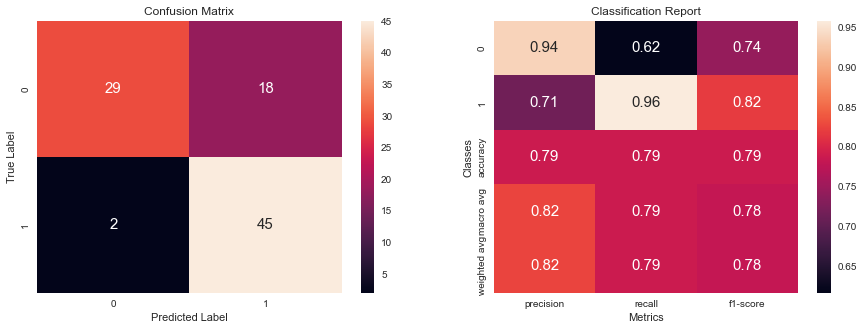

In [424]:
plot_cm_cr(hig_qda)

<h1>3. Petrosian FD</h1>

In [295]:
df_petrosian = pd.DataFrame(petrosian_dict)

In [296]:
alcoholic = df_petrosian[df_petrosian['subject_identifier'] == 'a']
alcoholic

,name,trial_number,matching_condition,subject_identifier,AF3,AF4,AF7,AF8,AFz,C1,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
0,co2a0000364,0,S1 obj,a,1.019075,1.019339,1.018547,1.020129,1.018812,1.047026,...,1.019075,1.020391,1.043637,1.042662,1.020129,1.019866,1.019075,1.019075,1.019075,1.018018
1,co2a0000364,18,S1 obj,a,1.016426,1.018283,1.017489,1.018547,1.018547,1.041193,...,1.015893,1.018547,1.041928,1.045578,1.016426,1.018018,1.021178,1.019339,1.019075,1.018812
2,co2a0000369,13,"S2 nomatch,",a,1.014825,1.012945,1.014825,1.014021,1.012945,1.017489,...,1.011595,1.012676,1.015893,1.015626,1.011054,1.011054,1.010511,1.011595,1.011054,1.014289
3,co2a0000369,14,S1 obj,a,1.008330,1.009967,1.006958,1.012136,1.009967,1.016160,...,1.011325,1.010782,1.012406,1.011325,1.010782,1.009967,1.009695,1.010511,1.009695,1.011325
4,co2a0000369,15,"S2 nomatch,",a,1.011054,1.010782,1.016426,1.010782,1.011325,1.021702,...,1.015626,1.014557,1.016160,1.016692,1.014557,1.015359,1.012676,1.012136,1.014825,1.012406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,co2a0000369,8,S1 obj,a,1.010239,1.011325,1.011325,1.013214,1.011325,1.018547,...,1.014289,1.014557,1.015359,1.015893,1.014021,1.011595,1.009423,1.012676,1.011325,1.013483
464,co2a0000369,9,S2 match,a,1.011595,1.014289,1.012676,1.012676,1.011595,1.016426,...,1.013214,1.012676,1.014825,1.013214,1.011054,1.010239,1.009967,1.011595,1.011054,1.012676
465,co2a0000369,10,S1 obj,a,1.008330,1.008330,1.008330,1.008330,1.008330,1.017489,...,1.012676,1.012406,1.011054,1.010782,1.011595,1.013214,1.007782,1.010239,1.008330,1.009695
466,co2a0000369,11,S2 match,a,1.018283,1.015092,1.014825,1.016426,1.016692,1.018018,...,1.014557,1.013214,1.016692,1.016426,1.015359,1.016160,1.010782,1.013752,1.011866,1.014825


In [297]:
non_alcoholic = df_petrosian[df_petrosian['subject_identifier'] == 'c']
non_alcoholic

,name,trial_number,matching_condition,subject_identifier,AF3,AF4,AF7,AF8,AFz,C1,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
152,co2c0000337,0,S1 obj,c,1.014825,1.013214,1.015359,1.016160,1.013214,1.041928,...,1.013752,1.013214,1.041193,1.044123,1.015359,1.014825,1.016426,1.016692,1.013752,1.016426
153,co2c0000337,2,S1 obj,c,1.018283,1.016160,1.017489,1.017754,1.016160,1.043393,...,1.014825,1.015092,1.044366,1.042906,1.013752,1.016426,1.015626,1.018812,1.014021,1.016426
154,co2c0000337,16,S1 obj,c,1.015626,1.016160,1.016692,1.018283,1.015092,1.042417,...,1.015359,1.012945,1.041683,1.040211,1.012945,1.013483,1.018018,1.016958,1.018018,1.018283
155,co2c0000337,17,S2 match,c,1.014557,1.014557,1.015626,1.017754,1.014557,1.046544,...,1.012676,1.016426,1.041193,1.043149,1.009695,1.010782,1.019339,1.018812,1.016692,1.017754
157,co2c0000337,21,"S2 nomatch,",c,1.016160,1.014825,1.017489,1.016426,1.015626,1.039225,...,1.016160,1.013214,1.042662,1.040702,1.012136,1.014289,1.018283,1.016692,1.015626,1.018812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,co2c0000345,31,"S2 nomatch,",c,1.012136,1.011325,1.012136,1.013752,1.011595,1.012136,...,1.012945,1.012136,1.013483,1.014289,1.014289,1.013214,1.014021,1.011866,1.012406,1.011866
406,co2c0000345,33,"S2 nomatch,",c,1.009150,1.009695,1.010782,1.011054,1.009967,1.013483,...,1.013483,1.012406,1.014021,1.010782,1.012945,1.014021,1.010782,1.011866,1.010511,1.012406
407,co2c0000345,37,S2 match,c,1.009150,1.010782,1.011325,1.011866,1.009150,1.016692,...,1.012945,1.014021,1.012945,1.011866,1.013214,1.011325,1.012136,1.012945,1.012945,1.012136
408,co2c0000345,41,S2 match,c,1.011595,1.012676,1.012676,1.012136,1.012676,1.015626,...,1.013214,1.013214,1.013214,1.015893,1.015359,1.012676,1.012945,1.013752,1.010239,1.013214


<AxesSubplot:>

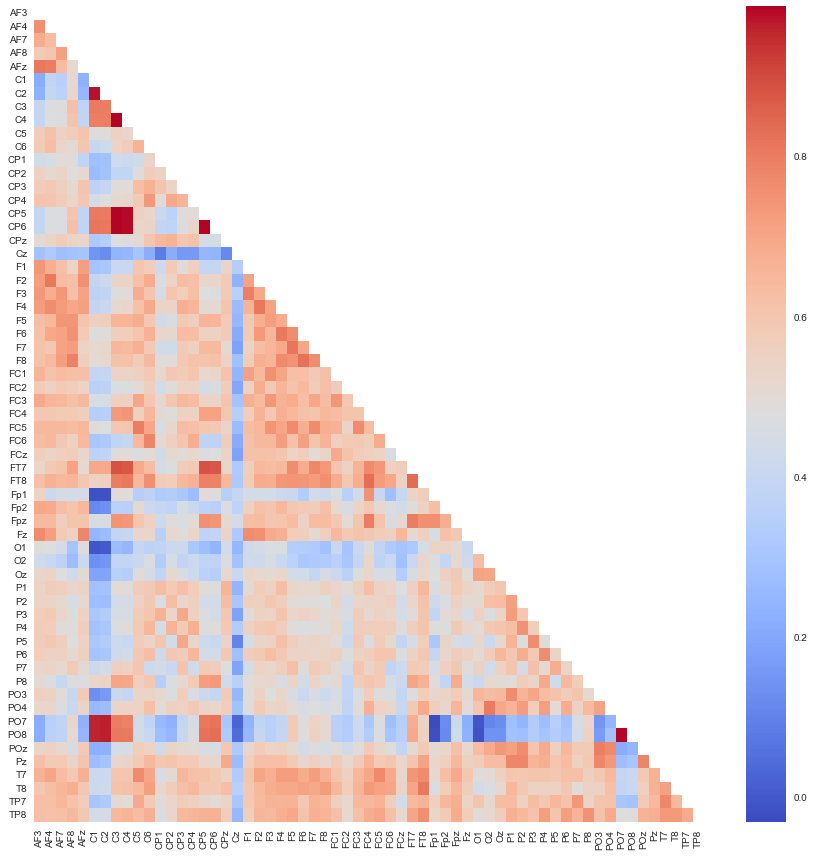

In [298]:
fig, ax = plt.subplots(figsize=(15,15))

mask = np.triu(np.ones_like(alcoholic.iloc[:, 4:].corr()))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(alcoholic.iloc[:, 4:].corr(), mask=mask, ax=ax, cmap='coolwarm')

<AxesSubplot:>

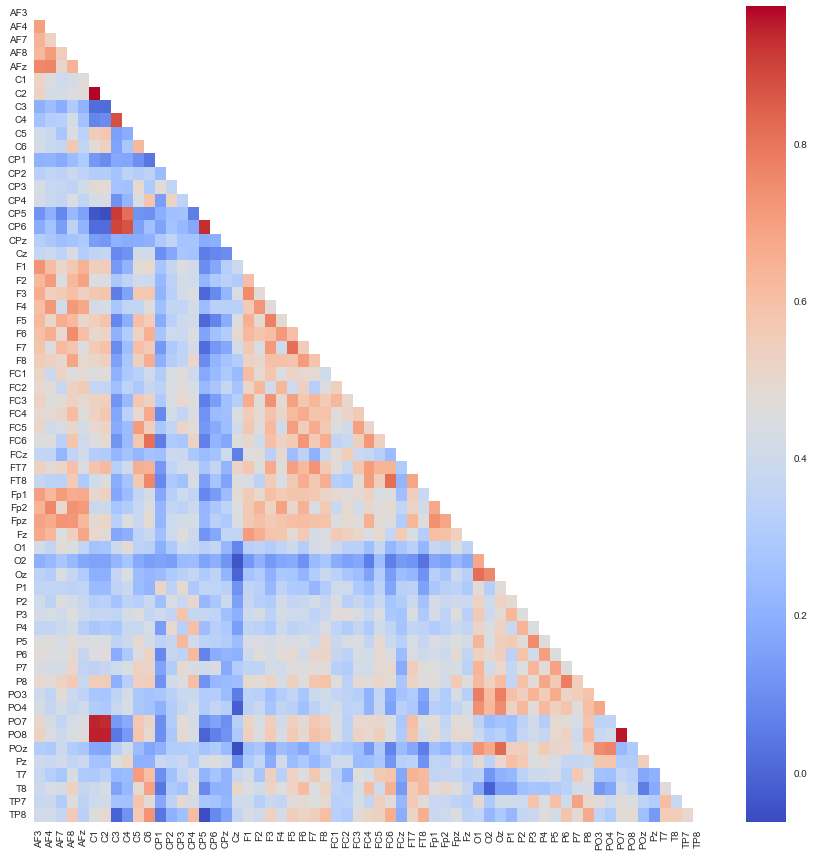

In [299]:
fig, ax = plt.subplots(figsize=(15,15))

mask = np.triu(np.ones_like(non_alcoholic.iloc[:, 4:].corr()))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(non_alcoholic.iloc[:, 4:].corr(), mask=mask, ax=ax, cmap='coolwarm')

<h2>Machine Learning</h2>

In [300]:
df_petrosian['subject_identifier'] = df_petrosian['subject_identifier'].apply(lambda x: 1 if (x == 'a') else 0)
df_petrosian['subject_identifier'].value_counts()

1    235
0    233
Name: subject_identifier, dtype: int64

In [301]:
X = df_petrosian.iloc[:, 4:]
Y = df_petrosian['subject_identifier']
X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)
log_reg = LogisticRegression(solver = 'lbfgs', max_iter = 1000000)

In [302]:
X_train

,AF3,AF4,AF7,AF8,AFz,C1,C2,C3,C4,C5,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
148,1.015626,1.015092,1.015626,1.016426,1.015092,1.018283,1.015893,1.016426,1.016426,1.016692,...,1.016692,1.015626,1.017223,1.016692,1.015626,1.015092,1.017223,1.014825,1.016692,1.016426
131,1.019075,1.016160,1.018547,1.017489,1.017489,1.017754,1.018812,1.016160,1.016958,1.019339,...,1.018018,1.017489,1.018018,1.017489,1.016958,1.016692,1.018283,1.018547,1.017754,1.017489
437,1.019075,1.019075,1.019075,1.019603,1.019603,1.038483,1.037740,1.043637,1.045578,1.018547,...,1.015626,1.015626,1.039471,1.040948,1.016692,1.018547,1.018283,1.018283,1.017223,1.018547
317,1.016958,1.017489,1.020129,1.016692,1.017489,1.038236,1.037244,1.023786,1.025340,1.013483,...,1.015893,1.018547,1.038731,1.042417,1.016958,1.017489,1.014021,1.015893,1.012945,1.015359
400,1.014825,1.013214,1.016160,1.019075,1.012136,1.040456,1.040456,1.040456,1.044123,1.013483,...,1.012945,1.012945,1.043393,1.042417,1.012406,1.012676,1.014825,1.015359,1.016692,1.016426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,1.014557,1.014021,1.012406,1.014825,1.015626,1.033746,1.032235,1.021702,1.019339,1.013214,...,1.011866,1.013214,1.029699,1.033746,1.013752,1.014289,1.013483,1.015626,1.013483,1.012406
98,1.016160,1.016958,1.016692,1.016426,1.014825,1.016958,1.020654,1.016160,1.014825,1.014557,...,1.014825,1.019603,1.017489,1.017489,1.016426,1.014825,1.015626,1.013214,1.016160,1.016426
322,1.013214,1.015626,1.012406,1.019075,1.014289,1.041438,1.037988,1.043637,1.042173,1.018283,...,1.014289,1.012676,1.043880,1.041438,1.013214,1.015893,1.016958,1.016160,1.016160,1.017223
382,1.009423,1.013214,1.011054,1.013752,1.013214,1.015359,1.016692,1.013214,1.012945,1.013214,...,1.013214,1.012676,1.012136,1.012136,1.013214,1.012406,1.011054,1.013483,1.014289,1.012945


In [303]:
np.mean(X_train.isnull().mean())

0.0

<h2>Logistic Regression: 77.66%</h2>

In [304]:
log_reg.fit(X_train, y_train)
y_predicted = log_reg.predict(X_test)
print(accuracy_score(y_test,y_predicted))

0.776595744680851


<h2>Naive Bayes: 50%</h2>

In [305]:
MNB = MultinomialNB()
MNB.fit(X_train, y_train)
predicted = MNB.predict(X_test)
print(accuracy_score(y_test, predicted))

0.5


<h2>Random Forest: 96.80%</h2>

In [306]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9680851063829787


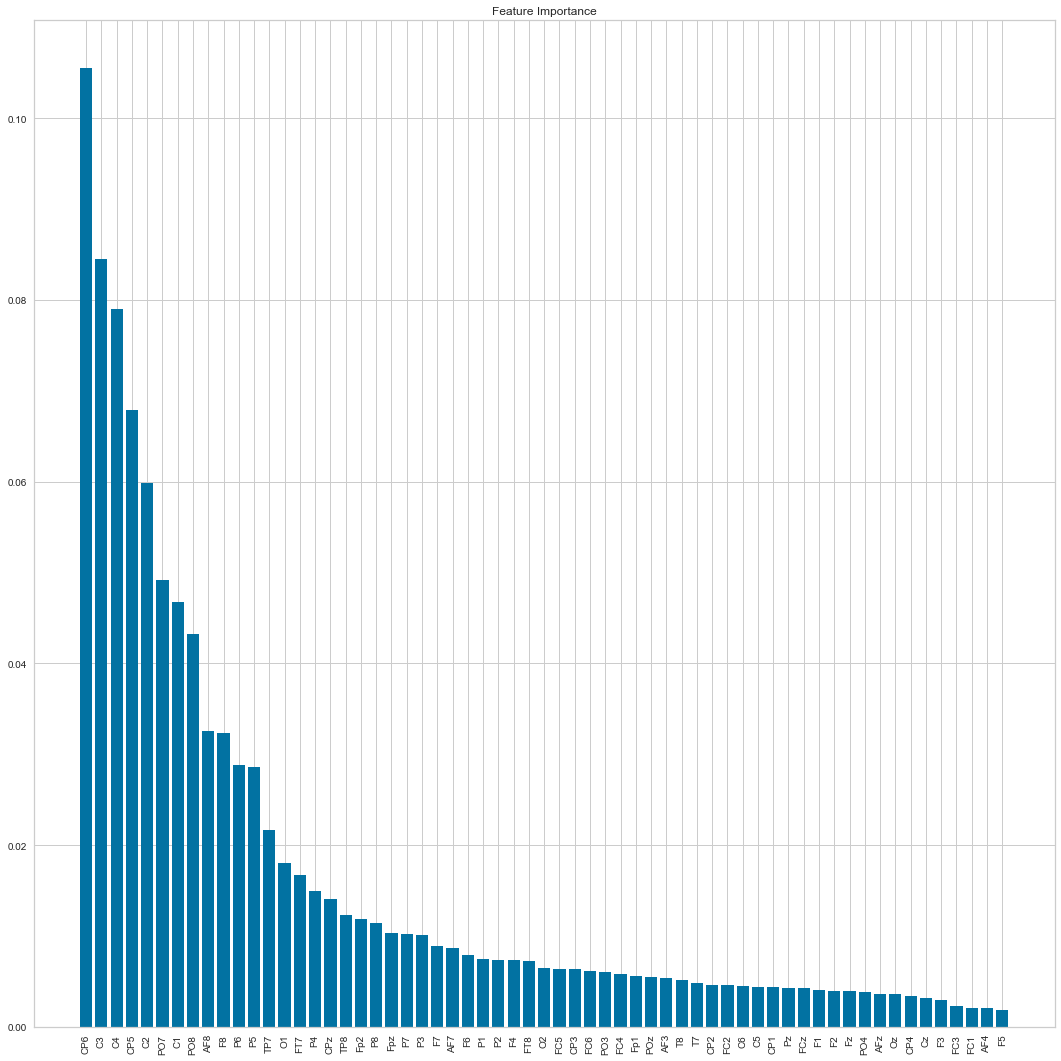

In [307]:
importances = clf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots(figsize=(15,15))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

<h2>Pycaret</h2>

In [308]:
from pycaret.classification import *

In [309]:
for col in df_katz.columns:
    if df_katz[col].isnull().sum() != 0:
        print(col)

Cz
O2


In [311]:
clf = setup(data=pd.concat([X_train, y_train], axis=1), target='subject_identifier', normalize=True)

,Description,Value
0,session_id,2636
1,Target,subject_identifier
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(374, 62)"
5,Missing Values,False
6,Numeric Features,61
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [312]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9771,0.9902,0.9750,0.9763,0.9750,0.9538,0.9549,0.0500
rf,Random Forest Classifier,0.9732,0.9947,0.9667,0.9763,0.9706,0.9460,0.9474,0.0540
knn,K Neighbors Classifier,0.9655,0.9853,0.9583,0.9686,0.9623,0.9306,0.9325,0.0110
lightgbm,Light Gradient Boosting Machine,0.9501,0.9888,0.9583,0.9406,0.9475,0.9002,0.9034,0.0130
gbc,Gradient Boosting Classifier,0.9463,0.9859,0.9417,0.9441,0.9416,0.8919,0.8940,0.0310
xgboost,Extreme Gradient Boosting,0.9463,0.9905,0.9417,0.9449,0.9419,0.8920,0.8941,0.0460
ada,Ada Boost Classifier,0.9426,0.9786,0.9250,0.9490,0.9358,0.8840,0.8858,0.0220
dt,Decision Tree Classifier,0.9232,0.9217,0.9000,0.9345,0.9133,0.8447,0.8495,0.0050
lr,Logistic Regression,0.8623,0.9344,0.8417,0.8571,0.8479,0.7222,0.7241,0.0100
svm,SVM - Linear Kernel,0.8432,0.0000,0.8167,0.8454,0.8250,0.6836,0.6905,0.0050


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=2636, verbose=0,
                     warm_start=False)

In [314]:
PFD_et = create_model('et', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9623,0.9986,1.0000,0.9231,0.9600,0.9244,0.9270
1,0.9423,0.9613,0.9583,0.9200,0.9388,0.8843,0.8849
2,0.9615,0.9754,0.9583,0.9583,0.9583,0.9226,0.9226
3,0.9615,1.0000,0.9167,1.0000,0.9565,0.9222,0.9250
4,0.9808,1.0000,0.9583,1.0000,0.9787,0.9612,0.9619
Mean,0.9617,0.9871,0.9583,0.9603,0.9585,0.9229,0.9243
Std,0.0122,0.0159,0.0264,0.0351,0.0127,0.0243,0.0244


In [316]:
PFD_tuned_et = tune_model(PFD_et, fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9623,1.0000,1.0000,0.9231,0.9600,0.9244,0.9270
1,0.9423,0.9792,0.9583,0.9200,0.9388,0.8843,0.8849
2,0.9808,0.9747,0.9583,1.0000,0.9787,0.9612,0.9619
3,0.9808,1.0000,0.9583,1.0000,0.9787,0.9612,0.9619
4,0.9808,1.0000,0.9583,1.0000,0.9787,0.9612,0.9619
Mean,0.9694,0.9908,0.9667,0.9686,0.9670,0.9384,0.9395
Std,0.0153,0.0114,0.0167,0.0385,0.0159,0.0306,0.0305


In [318]:
PFD_tuned_et

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight={},
                     criterion='entropy', max_depth=7, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0005, min_impurity_split=None,
                     min_samples_leaf=2, min_samples_split=5,
                     min_weight_fraction_leaf=0.0, n_estimators=160, n_jobs=-1,
                     oob_score=False, random_state=2636, verbose=0,
                     warm_start=False)

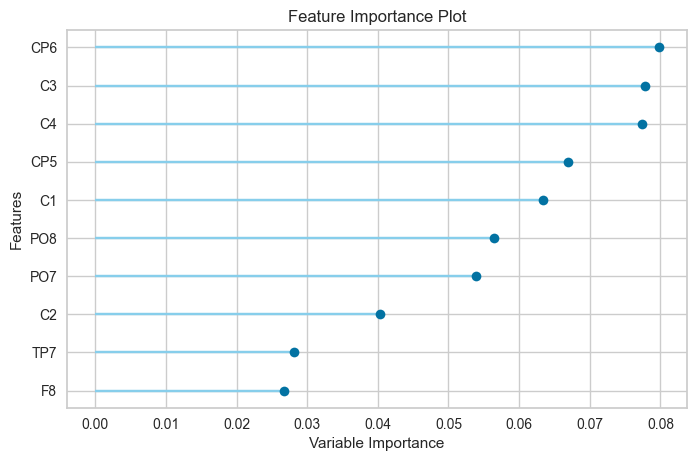

In [317]:
plot_model(PFD_tuned_et, plot='feature')

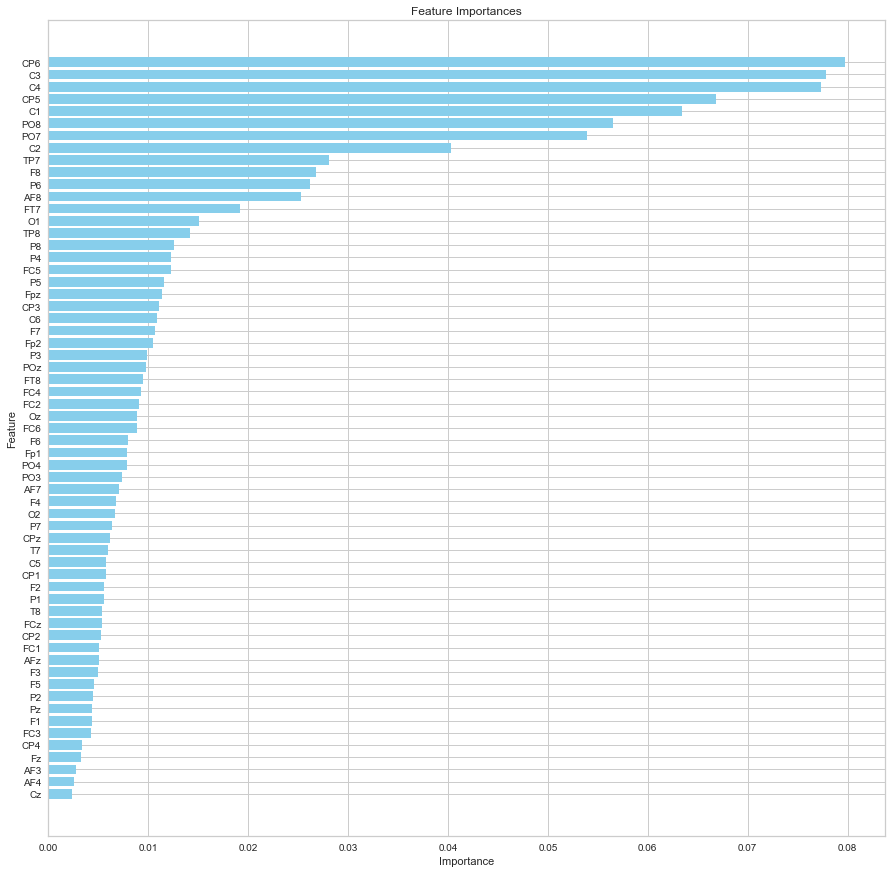

In [320]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = PFD_tuned_et.feature_importances_

# Create a DataFrame to hold feature names and their importance values
importances_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

# Sort the DataFrame by importance in descending order
importances_df = importances_df.sort_values('importance', ascending=True)

# Plot
plt.figure(figsize=(15, 15))  # Adjust as needed
plt.barh(importances_df['feature'], importances_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()


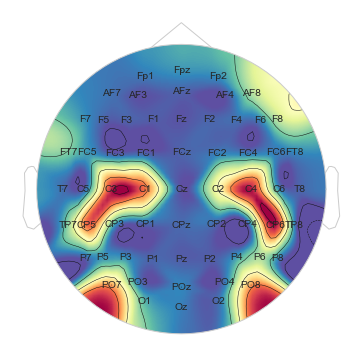

(<matplotlib.image.AxesImage at 0x1eb4cdca490>,
 <matplotlib.contour.QuadContourSet at 0x1eb4cdbca60>)

In [321]:
from matplotlib.colors import TwoSlopeNorm
plt.rcParams.update({'font.size': 15})  # or whatever size you want
cnorm = TwoSlopeNorm(vmin=min(importances), vcenter=(min(importances) + max(importances))/2, vmax=max(importances))
mne.viz.plot_topomap(data=importances, pos=raw.info, names=X_train.columns, show_names=True, cnorm=cnorm, cmap='Spectral_r')

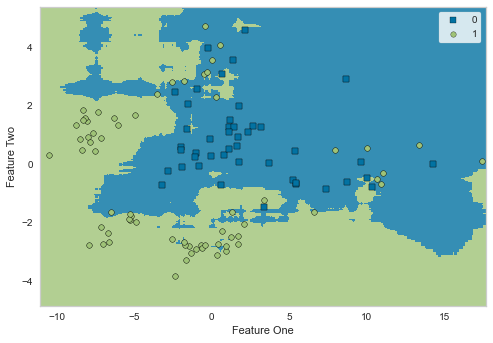

In [325]:
plot_model(hig_et, plot='boundary')


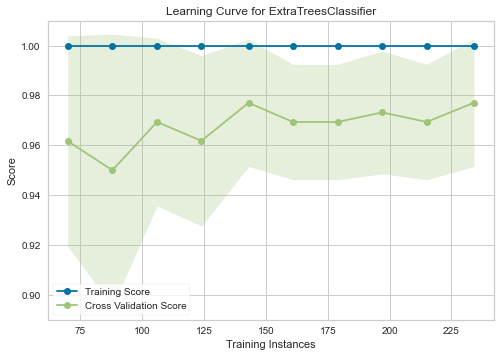

In [326]:
plot_model(hig_et, plot='learning')


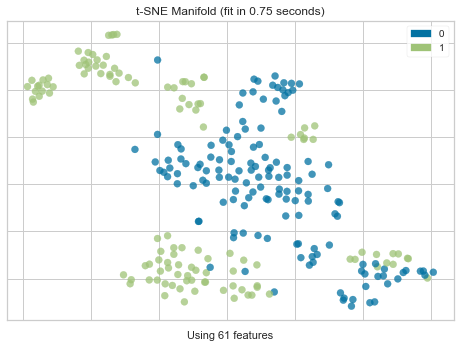

In [327]:
plot_model(hig_et, plot='manifold')

In [328]:
predictions = predict_model(hig_qda, data=pd.concat([X_test, y_test], axis=1))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Quadratic Discriminant Analysis,0.7872,0.8601,0.9787,0.7077,0.8214,0.5745,0.6219


In [329]:
predictions

,AF3,AF4,AF7,AF8,AFz,C1,C2,C3,C4,C5,...,PO8,POz,Pz,T7,T8,TP7,TP8,subject_identifier,Label,Score
48,1.015092,1.014557,1.017489,1.019603,1.015092,1.018812,1.018018,1.016692,1.016958,1.015092,...,1.015626,1.015092,1.015626,1.013483,1.013214,1.014289,1.014289,1,1,1.0000
355,1.012676,1.011595,1.016958,1.014289,1.013214,1.016160,1.019603,1.026628,1.026371,1.012945,...,1.012676,1.013214,1.013752,1.014825,1.015359,1.012136,1.012676,0,1,0.9994
85,1.015359,1.015893,1.015893,1.020391,1.014557,1.020654,1.021702,1.039964,1.041438,1.016160,...,1.019339,1.016958,1.017223,1.015893,1.019603,1.018812,1.017223,1,1,1.0000
34,1.016426,1.021702,1.018547,1.020129,1.018283,1.045094,1.042662,1.045094,1.040702,1.020129,...,1.044851,1.014289,1.016426,1.018547,1.019339,1.018812,1.016958,1,1,1.0000
11,1.013214,1.012676,1.014825,1.012136,1.013752,1.019075,1.017754,1.015092,1.016426,1.015359,...,1.014557,1.013214,1.011595,1.012676,1.014289,1.013752,1.012676,1,1,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,1.016692,1.017754,1.018547,1.020129,1.015626,1.039964,1.039471,1.042906,1.042906,1.018018,...,1.040948,1.016692,1.017223,1.020391,1.018547,1.018283,1.019075,1,1,1.0000
419,1.013752,1.015359,1.017489,1.018018,1.014289,1.039718,1.038731,1.040702,1.035999,1.016958,...,1.044123,1.015359,1.012136,1.014557,1.013214,1.017754,1.018283,1,1,1.0000
336,1.015359,1.018547,1.017489,1.016160,1.016958,1.038483,1.039964,1.024823,1.026886,1.018018,...,1.041683,1.019075,1.017489,1.015893,1.015359,1.013752,1.014289,0,0,1.0000
414,1.016160,1.016958,1.019603,1.019866,1.016958,1.037988,1.040702,1.040948,1.038236,1.016692,...,1.041193,1.016160,1.014557,1.016160,1.014825,1.015359,1.014825,1,1,1.0000


In [330]:
# import classification report and confusion matrix from sklearn library
from sklearn.metrics import classification_report, confusion_matrix

# create a function to plot confusion matrix and classification report
def plot_cm_cr(model):
    # create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    # plot confusion matrix on 1st subplot
    sns.heatmap(confusion_matrix(predictions['subject_identifier'], predictions['Label']), annot=True, fmt='d', ax=ax[0])
    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('Predicted Label')
    ax[0].set_ylabel('True Label')
    
    # plot classification report on 2nd subplot
    sns.heatmap(pd.DataFrame(classification_report(predictions['subject_identifier'], predictions['Label'], output_dict=True)).iloc[:-1, :].T, annot=True, ax=ax[1])
    ax[1].set_title('Classification Report')
    ax[1].set_xlabel('Metrics')
    ax[1].set_ylabel('Classes')

    print(classification_report(predictions['subject_identifier'], predictions['Label']))

              precision    recall  f1-score   support

           0       0.97      0.60      0.74        47
           1       0.71      0.98      0.82        47

    accuracy                           0.79        94
   macro avg       0.84      0.79      0.78        94
weighted avg       0.84      0.79      0.78        94



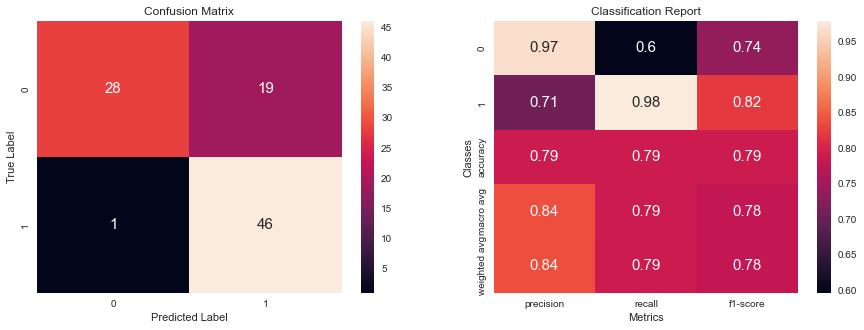

In [331]:
plot_cm_cr(hig_qda)

Petrosian FD Does not perform as good as Higuchi

<h1>4. Spectral Entropy</h1>

In [347]:
df_spec_ent = pd.DataFrame(spec_ent_dict)
df_spec_ent

,name,trial_number,matching_condition,subject_identifier,AF3,AF4,AF7,AF8,AFz,C1,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
0,co2a0000364,0,S1 obj,a,0.528170,0.544690,0.669701,0.703125,0.456523,0.908873,...,0.597509,0.595940,0.889071,0.881413,0.603175,0.572494,0.724513,0.682540,0.738241,0.695338
1,co2a0000364,18,S1 obj,a,0.647483,0.674881,0.682364,0.639392,0.646591,0.923003,...,0.627933,0.673077,0.931055,0.890904,0.641162,0.640552,0.692507,0.663757,0.690444,0.644146
2,co2a0000369,13,"S2 nomatch,",a,0.572781,0.547467,0.562212,0.529052,0.547294,0.518277,...,0.616202,0.590438,0.643841,0.607216,0.599936,0.567176,0.516377,0.476230,0.529025,0.530723
3,co2a0000369,14,S1 obj,a,0.437151,0.454379,0.461795,0.491378,0.452386,0.552258,...,0.585482,0.592181,0.617684,0.574401,0.575417,0.536003,0.519793,0.545126,0.545605,0.550459
4,co2a0000369,15,"S2 nomatch,",a,0.466831,0.469102,0.458799,0.437263,0.458625,0.523686,...,0.586803,0.526558,0.620916,0.591140,0.544264,0.522252,0.482594,0.431371,0.536028,0.479938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,co2a0000369,8,S1 obj,a,0.450546,0.445299,0.484276,0.480609,0.442777,0.617441,...,0.562358,0.636420,0.577198,0.628130,0.593115,0.583969,0.492636,0.528948,0.466443,0.582125
464,co2a0000369,9,S2 match,a,0.507172,0.487211,0.493901,0.442571,0.511629,0.390566,...,0.441171,0.399861,0.440855,0.472551,0.446597,0.447366,0.422793,0.353920,0.424842,0.354188
465,co2a0000369,10,S1 obj,a,0.323576,0.311344,0.340868,0.309096,0.323541,0.407879,...,0.421440,0.472318,0.413588,0.386088,0.432843,0.622525,0.312887,0.313990,0.318276,0.327823
466,co2a0000369,11,S2 match,a,0.555810,0.522847,0.544815,0.541295,0.533298,0.502552,...,0.570852,0.552041,0.589519,0.593606,0.565118,0.594571,0.492451,0.513911,0.490478,0.515510


In [348]:
alcoholic = df_spec_ent[df_spec_ent['subject_identifier'] == 'a']
alcoholic

,name,trial_number,matching_condition,subject_identifier,AF3,AF4,AF7,AF8,AFz,C1,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
0,co2a0000364,0,S1 obj,a,0.528170,0.544690,0.669701,0.703125,0.456523,0.908873,...,0.597509,0.595940,0.889071,0.881413,0.603175,0.572494,0.724513,0.682540,0.738241,0.695338
1,co2a0000364,18,S1 obj,a,0.647483,0.674881,0.682364,0.639392,0.646591,0.923003,...,0.627933,0.673077,0.931055,0.890904,0.641162,0.640552,0.692507,0.663757,0.690444,0.644146
2,co2a0000369,13,"S2 nomatch,",a,0.572781,0.547467,0.562212,0.529052,0.547294,0.518277,...,0.616202,0.590438,0.643841,0.607216,0.599936,0.567176,0.516377,0.476230,0.529025,0.530723
3,co2a0000369,14,S1 obj,a,0.437151,0.454379,0.461795,0.491378,0.452386,0.552258,...,0.585482,0.592181,0.617684,0.574401,0.575417,0.536003,0.519793,0.545126,0.545605,0.550459
4,co2a0000369,15,"S2 nomatch,",a,0.466831,0.469102,0.458799,0.437263,0.458625,0.523686,...,0.586803,0.526558,0.620916,0.591140,0.544264,0.522252,0.482594,0.431371,0.536028,0.479938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,co2a0000369,8,S1 obj,a,0.450546,0.445299,0.484276,0.480609,0.442777,0.617441,...,0.562358,0.636420,0.577198,0.628130,0.593115,0.583969,0.492636,0.528948,0.466443,0.582125
464,co2a0000369,9,S2 match,a,0.507172,0.487211,0.493901,0.442571,0.511629,0.390566,...,0.441171,0.399861,0.440855,0.472551,0.446597,0.447366,0.422793,0.353920,0.424842,0.354188
465,co2a0000369,10,S1 obj,a,0.323576,0.311344,0.340868,0.309096,0.323541,0.407879,...,0.421440,0.472318,0.413588,0.386088,0.432843,0.622525,0.312887,0.313990,0.318276,0.327823
466,co2a0000369,11,S2 match,a,0.555810,0.522847,0.544815,0.541295,0.533298,0.502552,...,0.570852,0.552041,0.589519,0.593606,0.565118,0.594571,0.492451,0.513911,0.490478,0.515510


In [349]:
non_alcoholic = df_spec_ent[df_spec_ent['subject_identifier'] == 'c']
non_alcoholic

,name,trial_number,matching_condition,subject_identifier,AF3,AF4,AF7,AF8,AFz,C1,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
152,co2c0000337,0,S1 obj,c,0.610710,0.601576,0.542529,0.645755,0.504480,0.618124,...,0.589180,0.578763,0.830008,0.792307,0.605078,0.508005,0.603476,0.691309,0.546973,0.705350
153,co2c0000337,2,S1 obj,c,0.556995,0.538780,0.652175,0.582958,0.563378,0.620019,...,0.565319,0.605540,0.861334,0.845627,0.589816,0.506911,0.583754,0.717238,0.541612,0.717724
154,co2c0000337,16,S1 obj,c,0.643827,0.625677,0.657473,0.630167,0.638443,0.882534,...,0.517022,0.492935,0.751175,0.652254,0.498297,0.552104,0.610570,0.644911,0.492105,0.583827
155,co2c0000337,17,S2 match,c,0.423695,0.382313,0.483207,0.345900,0.381505,0.849629,...,0.486616,0.585011,0.792086,0.764141,0.495839,0.445984,0.653204,0.638824,0.561859,0.637015
157,co2c0000337,21,"S2 nomatch,",c,0.338580,0.312047,0.348172,0.260533,0.319027,0.859290,...,0.539127,0.585057,0.846757,0.834392,0.547670,0.485712,0.679273,0.710206,0.612602,0.699355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,co2c0000345,31,"S2 nomatch,",c,0.455027,0.463195,0.469625,0.486894,0.458162,0.627116,...,0.609877,0.571794,0.646838,0.618033,0.522927,0.508535,0.509319,0.551511,0.556559,0.561620
406,co2c0000345,33,"S2 nomatch,",c,0.555452,0.527356,0.510767,0.563847,0.542839,0.551322,...,0.604455,0.649804,0.616344,0.629901,0.594959,0.583543,0.426830,0.529748,0.472574,0.564699
407,co2c0000345,37,S2 match,c,0.506595,0.464343,0.458001,0.452854,0.474240,0.570313,...,0.576321,0.543957,0.590096,0.633236,0.584157,0.502007,0.517004,0.473404,0.517670,0.528899
408,co2c0000345,41,S2 match,c,0.509485,0.496856,0.537201,0.569238,0.483371,0.542808,...,0.500612,0.603608,0.587474,0.576487,0.571863,0.575620,0.524222,0.484886,0.512224,0.520385


<H2>Spectral Entropy shows the best Correlation Heatmap</H2>

<AxesSubplot:>

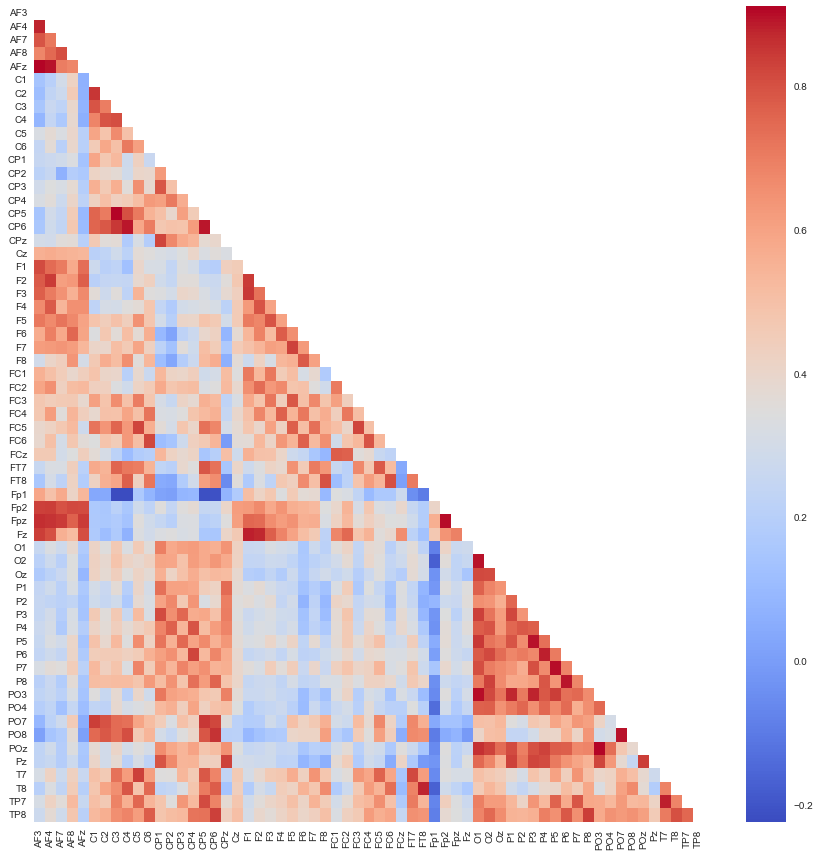

In [350]:
fig, ax = plt.subplots(figsize=(15,15))

mask = np.triu(np.ones_like(alcoholic.iloc[:, 4:].corr()))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(alcoholic.iloc[:, 4:].corr(), mask=mask, ax=ax, cmap='coolwarm')

<AxesSubplot:>

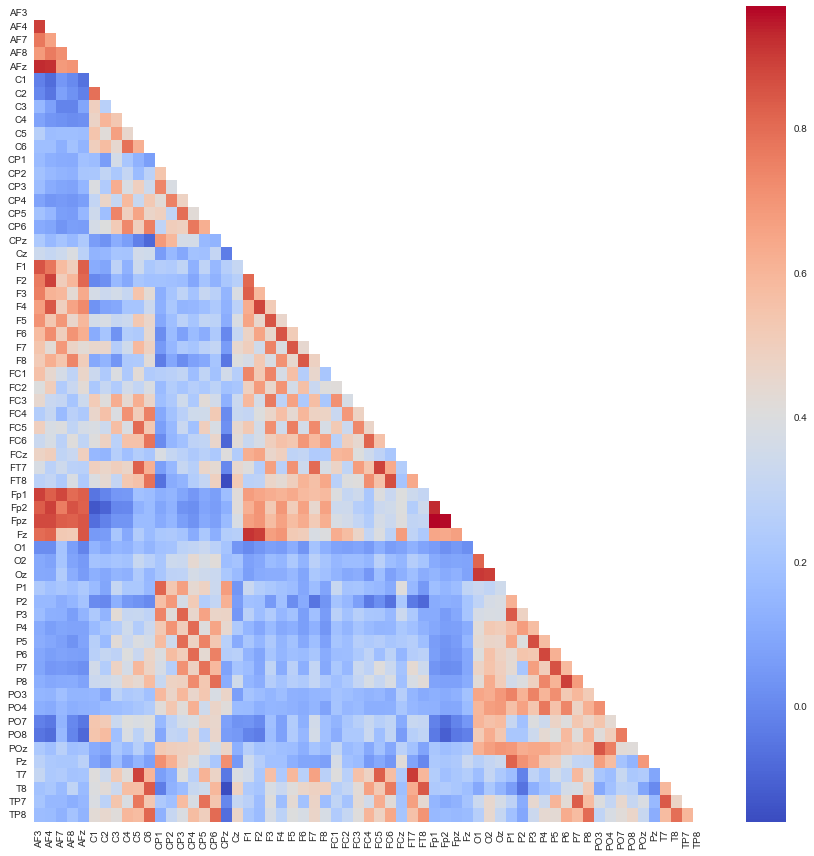

In [351]:
fig, ax = plt.subplots(figsize=(15,15))

mask = np.triu(np.ones_like(non_alcoholic.iloc[:, 4:].corr()))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(non_alcoholic.iloc[:, 4:].corr(), mask=mask, ax=ax, cmap='coolwarm')

<h2>Machine Learning</h2>

In [352]:
df_spec_ent['subject_identifier'] = df_spec_ent['subject_identifier'].apply(lambda x: 1 if (x == 'a') else 0)
df_spec_ent['subject_identifier'].value_counts()

1    235
0    233
Name: subject_identifier, dtype: int64

In [353]:
X = df_spec_ent.iloc[:, 4:]
Y = df_spec_ent['subject_identifier']
X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)
log_reg = LogisticRegression(solver = 'lbfgs', max_iter = 1000000)

In [354]:
X_train

,AF3,AF4,AF7,AF8,AFz,C1,C2,C3,C4,C5,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
148,0.652307,0.551847,0.632342,0.539540,0.623472,0.345158,0.394311,0.490832,0.564592,0.619205,...,0.413643,0.379900,0.476016,0.340045,0.385709,0.401611,0.619407,0.547059,0.563519,0.406985
131,0.394052,0.447789,0.301952,0.438650,0.444559,0.354339,0.303063,0.480856,0.476356,0.666328,...,0.538294,0.543576,0.534473,0.492879,0.518521,0.469046,0.658282,0.537080,0.661234,0.545859
437,0.431862,0.466902,0.392215,0.445523,0.344085,0.699233,0.685900,0.834203,0.835837,0.536661,...,0.607593,0.607632,0.770398,0.820661,0.575246,0.636257,0.558767,0.694891,0.515414,0.564951
317,0.489511,0.404542,0.697588,0.552513,0.485143,0.524777,0.531972,0.299121,0.426595,0.296424,...,0.456166,0.489511,0.605478,0.699520,0.490019,0.456750,0.332361,0.401362,0.326944,0.419953
400,0.494149,0.464510,0.631247,0.635398,0.517014,0.703159,0.811551,0.669262,0.716812,0.549237,...,0.577997,0.514886,0.899090,0.812571,0.574969,0.556789,0.511721,0.642474,0.608979,0.685136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,0.474428,0.486096,0.524387,0.485705,0.483644,0.582548,0.585560,0.519606,0.483012,0.497566,...,0.415813,0.461557,0.536867,0.457429,0.484284,0.490233,0.459377,0.421420,0.487478,0.447228
98,0.531635,0.495239,0.588607,0.622411,0.500957,0.618196,0.584132,0.627022,0.571439,0.523706,...,0.609828,0.574134,0.636739,0.590643,0.611384,0.615484,0.502160,0.548882,0.567751,0.531278
322,0.357263,0.364523,0.335819,0.411822,0.373424,0.802727,0.584322,0.841191,0.766119,0.664933,...,0.449399,0.421959,0.739060,0.632601,0.427961,0.449580,0.591795,0.533494,0.510857,0.524024
382,0.511403,0.467134,0.529853,0.435536,0.481207,0.605348,0.654202,0.551514,0.581598,0.583068,...,0.598872,0.618094,0.593701,0.635695,0.620357,0.622644,0.569604,0.613367,0.533736,0.623552


In [355]:
np.mean(X_train.isnull().mean())

0.0

<h2>Logistic Regression: 82.98%</h2>

In [356]:
log_reg.fit(X_train, y_train)
y_predicted = log_reg.predict(X_test)
print(accuracy_score(y_test,y_predicted))

0.8297872340425532


<h2>Naive Bayes 72.34% </h2>

In [357]:
MNB = MultinomialNB()
MNB.fit(X_train, y_train)
predicted = MNB.predict(X_test)
print(accuracy_score(y_test, predicted))

0.723404255319149


<h2>Random Forest: 81.91%</h2>

In [358]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8191489361702128


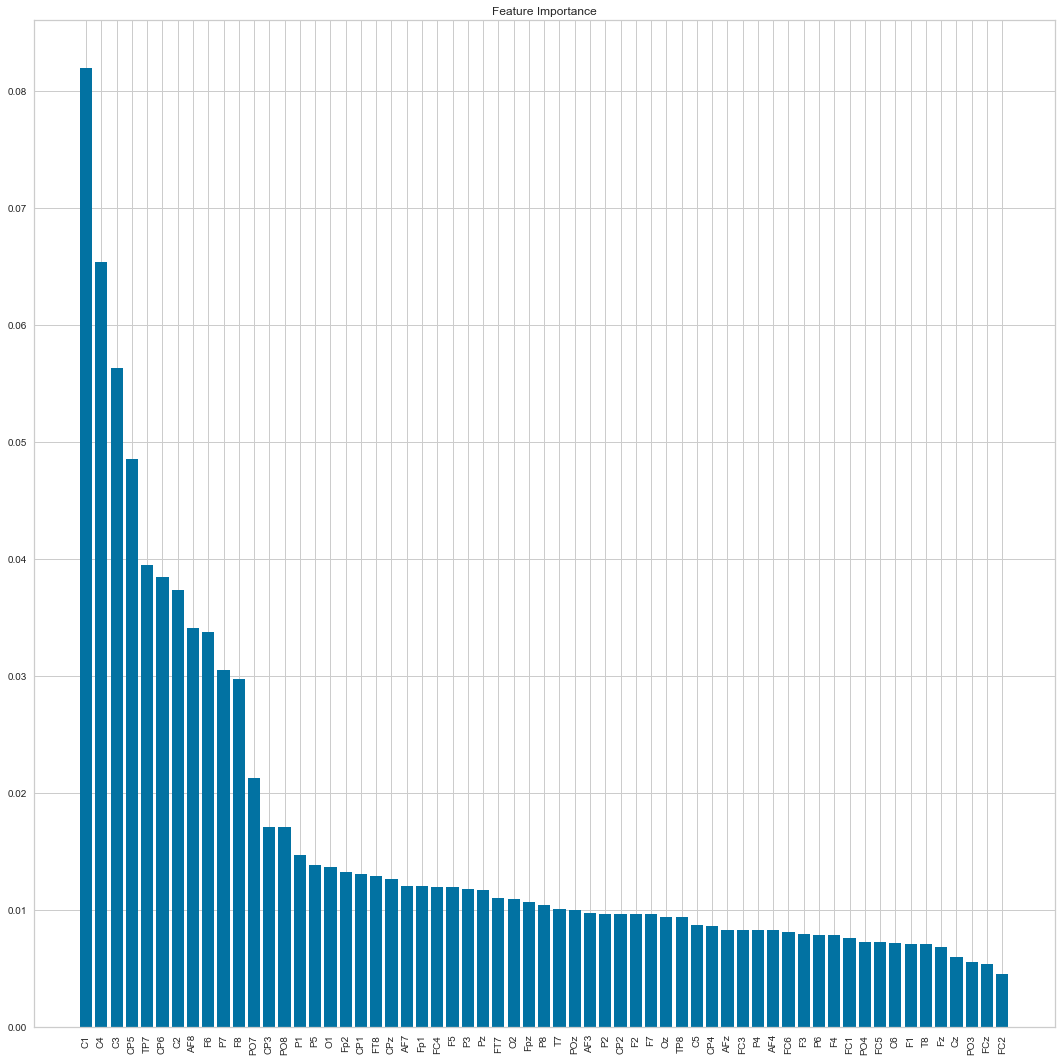

In [359]:
importances = clf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots(figsize=(15,15))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

<h2>Pycaret</h2>

In [360]:
from pycaret.classification import *

clf = setup(data=df_spec_ent.iloc[:,3:], target='subject_identifier', normalize=True)

,Description,Value
0,session_id,2089
1,Target,subject_identifier
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(468, 62)"
5,Missing Values,True
6,Numeric Features,61
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [361]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.8957,0.9623,0.8875,0.9056,0.8938,0.7912,0.7958,0.0070
lightgbm,Light Gradient Boosting Machine,0.8684,0.9443,0.8188,0.9082,0.8551,0.7361,0.7462,0.0190
xgboost,Extreme Gradient Boosting,0.8562,0.9407,0.8250,0.8803,0.8472,0.7120,0.7196,0.0500
rf,Random Forest Classifier,0.8528,0.9324,0.8125,0.8793,0.8377,0.7051,0.7142,0.0570
et,Extra Trees Classifier,0.8438,0.9414,0.8062,0.8668,0.8298,0.6869,0.6951,0.0500
gbc,Gradient Boosting Classifier,0.8409,0.9247,0.8000,0.8669,0.8281,0.6812,0.6879,0.0480
lr,Logistic Regression,0.8349,0.9169,0.8375,0.8311,0.8328,0.6697,0.6720,0.4950
ridge,Ridge Classifier,0.8317,0.0000,0.8250,0.8370,0.8286,0.6631,0.6674,0.0050
lda,Linear Discriminant Analysis,0.8288,0.8992,0.8125,0.8404,0.8235,0.6570,0.6620,0.0050
ada,Ada Boost Classifier,0.8160,0.9038,0.7812,0.8410,0.8045,0.6311,0.6388,0.0250


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [362]:
spec_ent_lgbm = create_model('lightgbm', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8485,0.9577,0.9062,0.8056,0.8529,0.6978,0.7030
1,0.8333,0.9338,0.7500,0.8889,0.8136,0.6648,0.6727
2,0.8462,0.9394,0.8125,0.8667,0.8387,0.6919,0.6933
3,0.8462,0.9176,0.7500,0.9231,0.8276,0.6914,0.7035
4,0.8462,0.9280,0.8438,0.8438,0.8438,0.6922,0.6922
Mean,0.8441,0.9353,0.8125,0.8656,0.8353,0.6876,0.6929
Std,0.0054,0.0133,0.0593,0.0398,0.0136,0.0116,0.0112


In [363]:
spec_ent_lgbm_tuned = tune_model(spec_ent_lgbm, fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7576,0.8676,0.8125,0.7222,0.7647,0.5165,0.5203
1,0.8939,0.9513,0.8750,0.9032,0.8889,0.7875,0.7879
2,0.8615,0.9280,0.8438,0.8710,0.8571,0.7229,0.7232
3,0.8000,0.8835,0.7812,0.8065,0.7937,0.5997,0.6000
4,0.8308,0.9081,0.8750,0.8000,0.8358,0.6619,0.6648
Mean,0.8288,0.9077,0.8375,0.8206,0.8280,0.6577,0.6592
Std,0.0474,0.0300,0.0364,0.0627,0.0443,0.0943,0.0933


In [364]:
spec_ent_lgbm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=2089, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

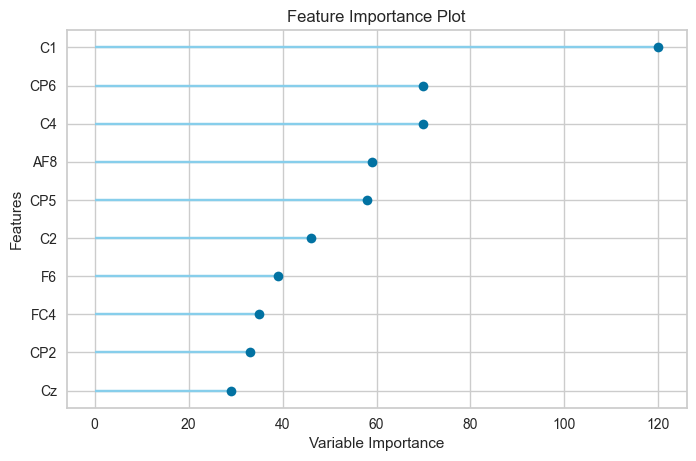

In [365]:
plot_model(spec_ent_lgbm, plot='feature')

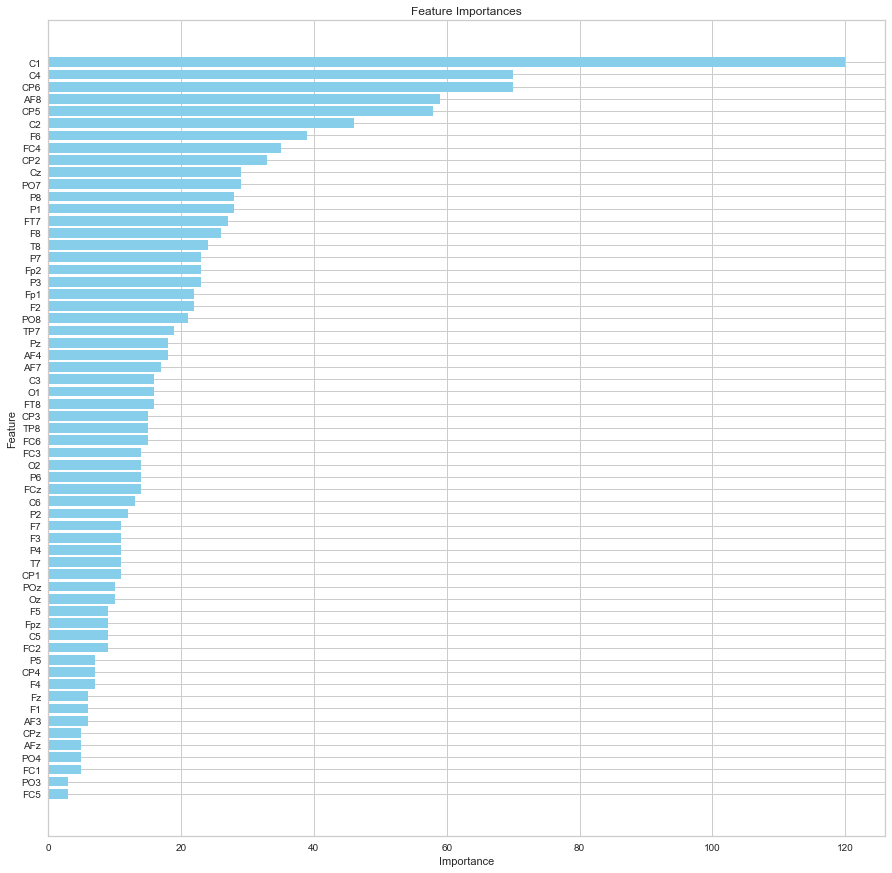

In [368]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = spec_ent_lgbm.feature_importances_

# Create a DataFrame to hold feature names and their importance values
importances_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

# Sort the DataFrame by importance in descending order
importances_df = importances_df.sort_values('importance', ascending=True)

# Plot
plt.figure(figsize=(15, 15))  # Adjust as needed
plt.barh(importances_df['feature'], importances_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()


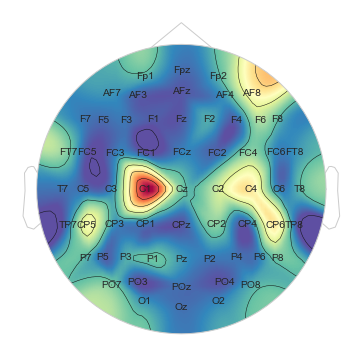

(<matplotlib.image.AxesImage at 0x1eb4d16a9a0>,
 <matplotlib.contour.QuadContourSet at 0x1eb4d172e80>)

In [369]:
from matplotlib.colors import TwoSlopeNorm
plt.rcParams.update({'font.size': 15})  # or whatever size you want
cnorm = TwoSlopeNorm(vmin=min(importances), vcenter=(min(importances) + max(importances))/2, vmax=max(importances))
mne.viz.plot_topomap(data=importances, pos=raw.info, names=X_train.columns, show_names=True, cnorm=cnorm, cmap='Spectral_r')

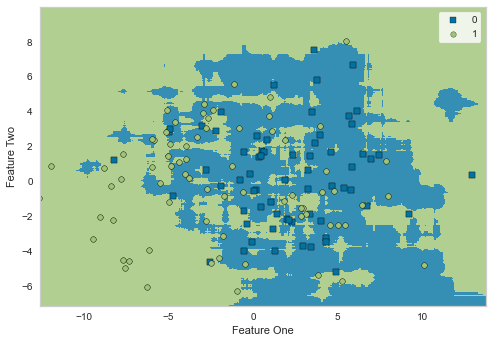

In [372]:
plot_model(hig_et, plot='boundary')


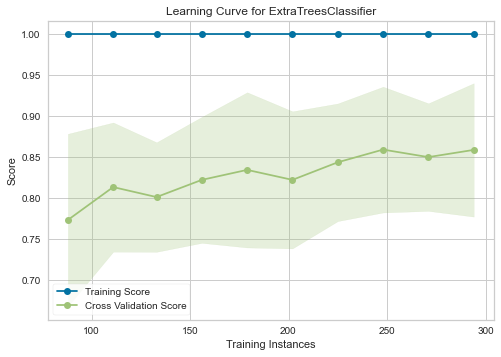

In [373]:
plot_model(hig_et, plot='learning')


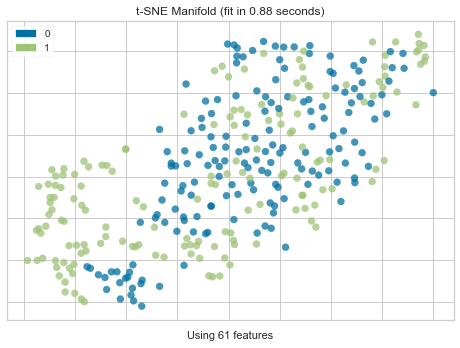

In [374]:
plot_model(hig_et, plot='manifold')

In [375]:
predictions = predict_model(hig_qda, data=pd.concat([X_test, y_test], axis=1))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Quadratic Discriminant Analysis,0.8723,0.8832,0.9362,0.8302,0.8800,0.7447,0.7508


In [376]:
predictions

,AF3,AF4,AF7,AF8,AFz,C1,C2,C3,C4,C5,...,PO8,POz,Pz,T7,T8,TP7,TP8,subject_identifier,Label,Score
48,0.624063,0.631183,0.707004,0.648033,0.627354,0.605964,0.594844,0.617495,0.536616,0.606284,...,0.560389,0.581567,0.569592,0.579908,0.560258,0.625969,0.548909,1,1,1.0
355,0.594590,0.614983,0.655241,0.649306,0.560871,0.566333,0.531774,0.610110,0.601420,0.623695,...,0.556489,0.618540,0.588347,0.659936,0.631080,0.626385,0.604496,0,0,1.0
85,0.652008,0.678964,0.675573,0.703441,0.674369,0.515172,0.667928,0.799026,0.808171,0.613804,...,0.667180,0.680423,0.654677,0.655603,0.663954,0.696490,0.648167,1,1,1.0
34,0.643139,0.707445,0.718104,0.683207,0.641409,0.912371,0.877683,0.907851,0.905115,0.689628,...,0.852522,0.520422,0.528760,0.703498,0.687111,0.711903,0.688435,1,1,1.0
11,0.461981,0.441901,0.456910,0.439786,0.438277,0.441564,0.380782,0.453971,0.443166,0.432697,...,0.490978,0.465720,0.477649,0.425522,0.356262,0.439886,0.380259,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,0.458724,0.596631,0.491902,0.652266,0.491374,0.823464,0.815038,0.886920,0.862059,0.710848,...,0.910636,0.659593,0.607580,0.710034,0.683579,0.719094,0.717265,1,1,1.0
419,0.547321,0.514275,0.719747,0.721948,0.493502,0.723943,0.777303,0.667632,0.767087,0.597935,...,0.806688,0.516688,0.475593,0.555869,0.644218,0.552326,0.659170,1,1,1.0
336,0.428085,0.471930,0.549198,0.514990,0.454270,0.661258,0.588897,0.547519,0.553953,0.456812,...,0.747596,0.491215,0.486723,0.436313,0.573342,0.467250,0.527336,0,0,1.0
414,0.560109,0.519039,0.628960,0.706675,0.550865,0.821180,0.776528,0.791146,0.741221,0.667367,...,0.887783,0.635876,0.629596,0.625296,0.621452,0.648719,0.680020,1,1,1.0


In [377]:
# import classification report and confusion matrix from sklearn library
from sklearn.metrics import classification_report, confusion_matrix

# create a function to plot confusion matrix and classification report
def plot_cm_cr(model):
    # create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    # plot confusion matrix on 1st subplot
    sns.heatmap(confusion_matrix(predictions['subject_identifier'], predictions['Label']), annot=True, fmt='d', ax=ax[0])
    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('Predicted Label')
    ax[0].set_ylabel('True Label')
    
    # plot classification report on 2nd subplot
    sns.heatmap(pd.DataFrame(classification_report(predictions['subject_identifier'], predictions['Label'], output_dict=True)).iloc[:-1, :].T, annot=True, ax=ax[1])
    ax[1].set_title('Classification Report')
    ax[1].set_xlabel('Metrics')
    ax[1].set_ylabel('Classes')

    print(classification_report(predictions['subject_identifier'], predictions['Label']))

              precision    recall  f1-score   support

           0       0.93      0.81      0.86        47
           1       0.83      0.94      0.88        47

    accuracy                           0.87        94
   macro avg       0.88      0.87      0.87        94
weighted avg       0.88      0.87      0.87        94



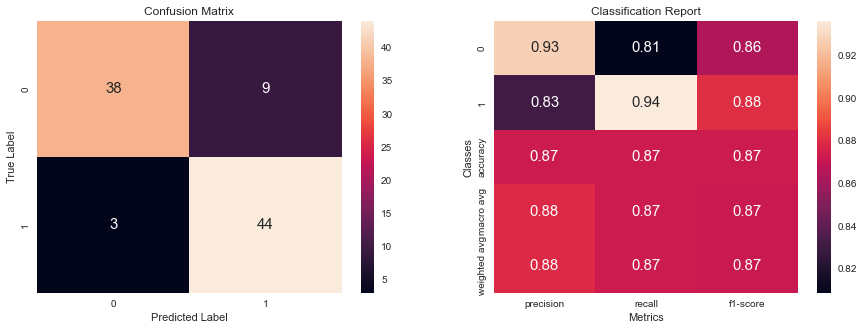

In [378]:
plot_cm_cr(spec_ent_lgbm)

<h2>5. Permutation Entropy</h2>

In [379]:
df_perm_ent = pd.DataFrame(perm_ent_dict)
df_perm_ent

,name,trial_number,matching_condition,subject_identifier,AF3,AF4,AF7,AF8,AFz,C1,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
0,co2a0000364,0,S1 obj,a,0.814746,0.823544,0.813404,0.835970,0.792354,0.987470,...,0.812293,0.830957,0.997574,0.998937,0.833299,0.821889,0.818081,0.820873,0.818075,0.800709
1,co2a0000364,18,S1 obj,a,0.781996,0.809219,0.798102,0.812518,0.811466,0.993285,...,0.736515,0.802643,0.996040,0.999234,0.776975,0.779939,0.845531,0.822276,0.819834,0.809233
2,co2a0000369,13,"S2 nomatch,",a,0.739808,0.720681,0.746486,0.736896,0.710637,0.665618,...,0.696502,0.707573,0.767034,0.767424,0.675438,0.654399,0.660505,0.694504,0.676372,0.738849
3,co2a0000369,14,S1 obj,a,0.620089,0.646003,0.598337,0.693886,0.645060,0.715335,...,0.685854,0.683611,0.709016,0.694646,0.682558,0.664498,0.659459,0.645617,0.651681,0.686142
4,co2a0000369,15,"S2 nomatch,",a,0.657374,0.660334,0.765089,0.660818,0.675245,0.687110,...,0.737243,0.743123,0.773579,0.771799,0.732427,0.751052,0.697494,0.700428,0.745049,0.695940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,co2a0000369,8,S1 obj,a,0.665597,0.666791,0.685945,0.717915,0.675312,0.689927,...,0.729293,0.750893,0.759685,0.763003,0.740477,0.695320,0.635601,0.707673,0.680673,0.709675
464,co2a0000369,9,S2 match,a,0.682889,0.726802,0.715145,0.704277,0.693336,0.695340,...,0.717187,0.713548,0.751280,0.726509,0.671652,0.636689,0.649501,0.690106,0.683688,0.680995
465,co2a0000369,10,S1 obj,a,0.613693,0.625783,0.623899,0.619109,0.616430,0.743081,...,0.713194,0.708963,0.688613,0.672246,0.692689,0.705442,0.617342,0.664107,0.630803,0.652538
466,co2a0000369,11,S2 match,a,0.780143,0.750369,0.737195,0.768308,0.769499,0.616659,...,0.748708,0.719345,0.773744,0.781509,0.748902,0.730615,0.665172,0.722182,0.679315,0.746445


In [380]:
alcoholic = df_perm_ent[df_perm_ent['subject_identifier'] == 'a']
alcoholic

,name,trial_number,matching_condition,subject_identifier,AF3,AF4,AF7,AF8,AFz,C1,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
0,co2a0000364,0,S1 obj,a,0.814746,0.823544,0.813404,0.835970,0.792354,0.987470,...,0.812293,0.830957,0.997574,0.998937,0.833299,0.821889,0.818081,0.820873,0.818075,0.800709
1,co2a0000364,18,S1 obj,a,0.781996,0.809219,0.798102,0.812518,0.811466,0.993285,...,0.736515,0.802643,0.996040,0.999234,0.776975,0.779939,0.845531,0.822276,0.819834,0.809233
2,co2a0000369,13,"S2 nomatch,",a,0.739808,0.720681,0.746486,0.736896,0.710637,0.665618,...,0.696502,0.707573,0.767034,0.767424,0.675438,0.654399,0.660505,0.694504,0.676372,0.738849
3,co2a0000369,14,S1 obj,a,0.620089,0.646003,0.598337,0.693886,0.645060,0.715335,...,0.685854,0.683611,0.709016,0.694646,0.682558,0.664498,0.659459,0.645617,0.651681,0.686142
4,co2a0000369,15,"S2 nomatch,",a,0.657374,0.660334,0.765089,0.660818,0.675245,0.687110,...,0.737243,0.743123,0.773579,0.771799,0.732427,0.751052,0.697494,0.700428,0.745049,0.695940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,co2a0000369,8,S1 obj,a,0.665597,0.666791,0.685945,0.717915,0.675312,0.689927,...,0.729293,0.750893,0.759685,0.763003,0.740477,0.695320,0.635601,0.707673,0.680673,0.709675
464,co2a0000369,9,S2 match,a,0.682889,0.726802,0.715145,0.704277,0.693336,0.695340,...,0.717187,0.713548,0.751280,0.726509,0.671652,0.636689,0.649501,0.690106,0.683688,0.680995
465,co2a0000369,10,S1 obj,a,0.613693,0.625783,0.623899,0.619109,0.616430,0.743081,...,0.713194,0.708963,0.688613,0.672246,0.692689,0.705442,0.617342,0.664107,0.630803,0.652538
466,co2a0000369,11,S2 match,a,0.780143,0.750369,0.737195,0.768308,0.769499,0.616659,...,0.748708,0.719345,0.773744,0.781509,0.748902,0.730615,0.665172,0.722182,0.679315,0.746445


In [381]:
non_alcoholic = df_perm_ent[df_perm_ent['subject_identifier'] == 'c']
non_alcoholic

,name,trial_number,matching_condition,subject_identifier,AF3,AF4,AF7,AF8,AFz,C1,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
152,co2c0000337,0,S1 obj,c,0.736759,0.720348,0.758765,0.769317,0.710459,0.996227,...,0.726211,0.725027,0.996053,0.998619,0.761951,0.735767,0.778578,0.782268,0.733308,0.782983
153,co2c0000337,2,S1 obj,c,0.796061,0.770606,0.791790,0.779101,0.770834,0.994092,...,0.732607,0.745739,0.999446,0.998402,0.735486,0.764772,0.763721,0.816762,0.716786,0.776195
154,co2c0000337,16,S1 obj,c,0.759077,0.771814,0.782085,0.805039,0.750373,0.992452,...,0.749636,0.704873,0.997206,0.991729,0.722413,0.726729,0.801797,0.787681,0.803537,0.807074
155,co2c0000337,17,S2 match,c,0.718982,0.718500,0.759760,0.796742,0.718896,0.994188,...,0.717595,0.763085,0.997072,0.997765,0.654334,0.681156,0.824265,0.816577,0.775348,0.796869
157,co2c0000337,21,"S2 nomatch,",c,0.766153,0.744617,0.791790,0.780342,0.754079,0.989249,...,0.772143,0.723005,0.995507,0.992887,0.690363,0.734397,0.807301,0.784225,0.764253,0.817661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,co2c0000345,31,"S2 nomatch,",c,0.707598,0.673951,0.699746,0.709310,0.688255,0.643468,...,0.716699,0.710854,0.734383,0.747555,0.734397,0.718596,0.730450,0.693929,0.715157,0.698996
406,co2c0000345,33,"S2 nomatch,",c,0.631154,0.658451,0.681532,0.682789,0.655888,0.655397,...,0.713696,0.714089,0.743536,0.681631,0.721655,0.724566,0.682015,0.691024,0.672623,0.714904
407,co2c0000345,37,S2 match,c,0.631550,0.658926,0.677445,0.690092,0.636333,0.709618,...,0.717684,0.727348,0.718530,0.696551,0.716995,0.684954,0.702586,0.716625,0.712406,0.691947
408,co2c0000345,41,S2 match,c,0.691841,0.708214,0.716102,0.707420,0.710657,0.690328,...,0.697975,0.709367,0.729417,0.764506,0.761155,0.709049,0.716442,0.733433,0.660107,0.714059


<AxesSubplot:>

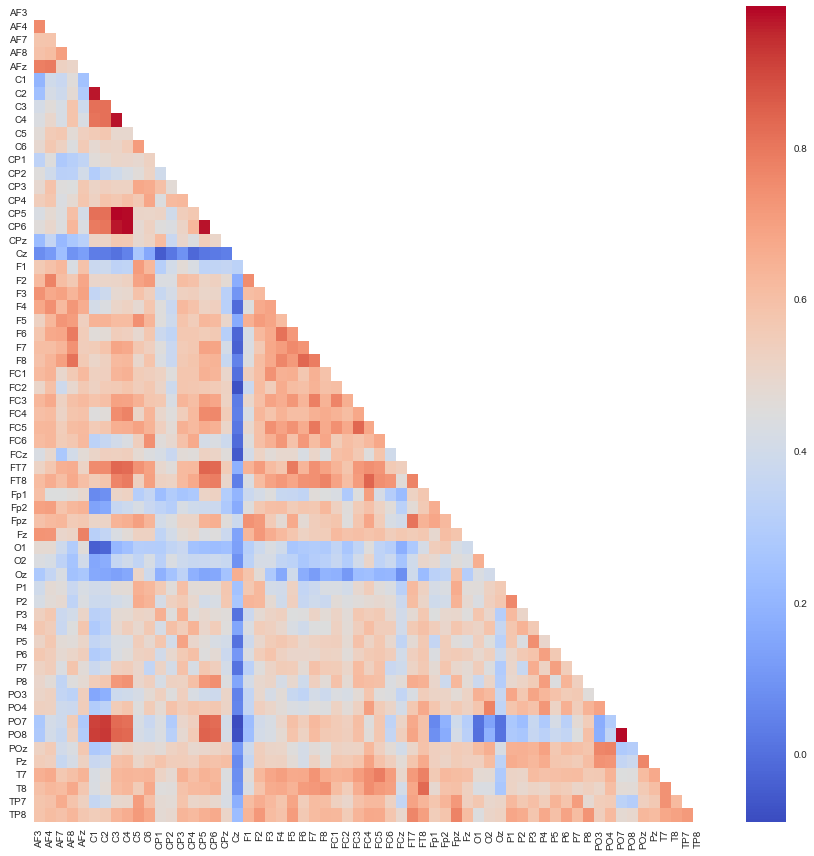

In [382]:
fig, ax = plt.subplots(figsize=(15,15))

mask = np.triu(np.ones_like(alcoholic.iloc[:, 4:].corr()))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(alcoholic.iloc[:, 4:].corr(), mask=mask, ax=ax, cmap='coolwarm')

<AxesSubplot:>

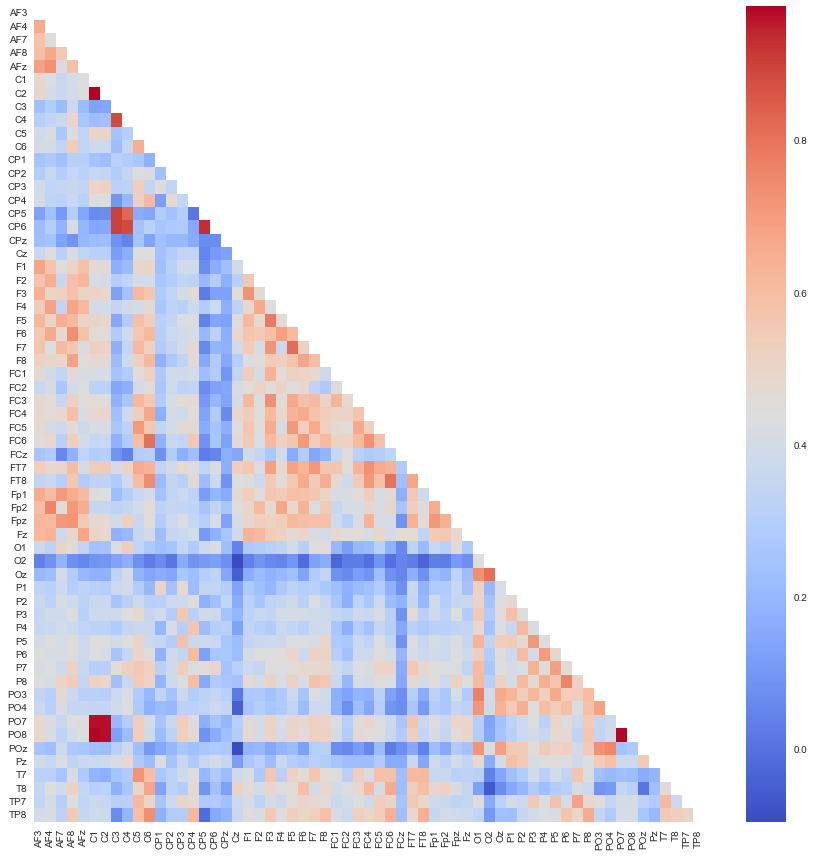

In [383]:
fig, ax = plt.subplots(figsize=(15,15))

mask = np.triu(np.ones_like(non_alcoholic.iloc[:, 4:].corr()))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(non_alcoholic.iloc[:, 4:].corr(), mask=mask, ax=ax, cmap='coolwarm')

<h2>Machine Learning</h2>

In [384]:
df_perm_ent['subject_identifier'] = df_perm_ent['subject_identifier'].apply(lambda x: 1 if (x == 'a') else 0)
df_perm_ent['subject_identifier'].value_counts()

X = df_perm_ent.iloc[:, 4:]
Y = df_perm_ent['subject_identifier']
X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123)
log_reg = LogisticRegression(solver = 'lbfgs', max_iter = 1000000)

In [385]:
X_train

,AF3,AF4,AF7,AF8,AFz,C1,C2,C3,C4,C5,...,PO3,PO4,PO7,PO8,POz,Pz,T7,T8,TP7,TP8
148,0.760081,0.753607,0.766583,0.775789,0.755707,0.734986,0.760193,0.767974,0.773024,0.772688,...,0.784760,0.762673,0.791490,0.774199,0.760430,0.743602,0.788822,0.741407,0.786640,0.774082
131,0.789731,0.766457,0.804960,0.780790,0.776723,0.688800,0.725037,0.768111,0.775802,0.820803,...,0.803823,0.799028,0.796556,0.795653,0.785056,0.756952,0.802976,0.807847,0.796555,0.795769
437,0.783882,0.807897,0.815535,0.827586,0.794539,0.988402,0.983797,0.998491,0.956863,0.791915,...,0.746123,0.757964,0.991549,0.996519,0.772793,0.783826,0.783824,0.809990,0.786278,0.805775
317,0.765802,0.737563,0.828219,0.776856,0.745099,0.975655,0.968635,0.852901,0.858172,0.708679,...,0.771948,0.801941,0.978048,0.994017,0.783771,0.757199,0.737645,0.720406,0.718715,0.726402
400,0.743607,0.716649,0.768278,0.816982,0.690457,0.988897,0.978217,0.984765,0.989128,0.725158,...,0.708903,0.696127,0.999391,0.991111,0.710539,0.706854,0.753030,0.750129,0.780178,0.778557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,0.738055,0.731869,0.697349,0.739787,0.734949,0.918646,0.920729,0.799382,0.795195,0.698718,...,0.671752,0.706475,0.922934,0.955021,0.714784,0.697029,0.706740,0.754444,0.706144,0.692520
98,0.753947,0.749102,0.776269,0.780320,0.715042,0.606523,0.664823,0.680778,0.703291,0.698962,...,0.737250,0.798496,0.790295,0.794285,0.751308,0.685786,0.720210,0.705950,0.731027,0.768687
322,0.702007,0.746936,0.708489,0.810960,0.738125,0.991959,0.983686,0.992956,0.986418,0.797207,...,0.736737,0.717363,0.998870,0.995150,0.720202,0.741253,0.772763,0.764027,0.762933,0.789337
382,0.652130,0.722228,0.683824,0.727683,0.715648,0.710412,0.741496,0.689768,0.700608,0.707498,...,0.720274,0.714052,0.692352,0.709397,0.725958,0.688720,0.683838,0.732810,0.737404,0.722087


In [386]:
np.mean(X_train.isnull().mean())

0.0

<h2>Logistic Regression: 78.72%</h2>

In [387]:
log_reg.fit(X_train, y_train)
y_predicted = log_reg.predict(X_test)
print(accuracy_score(y_test,y_predicted))

0.7872340425531915


<h2>Naive Bayes: 71.28%</h2>

In [388]:
MNB = MultinomialNB()
MNB.fit(X_train, y_train)
predicted = MNB.predict(X_test)
print(accuracy_score(y_test, predicted))

0.7127659574468085


<h2>Random Forest: 96.81%</h2>

In [389]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9787234042553191


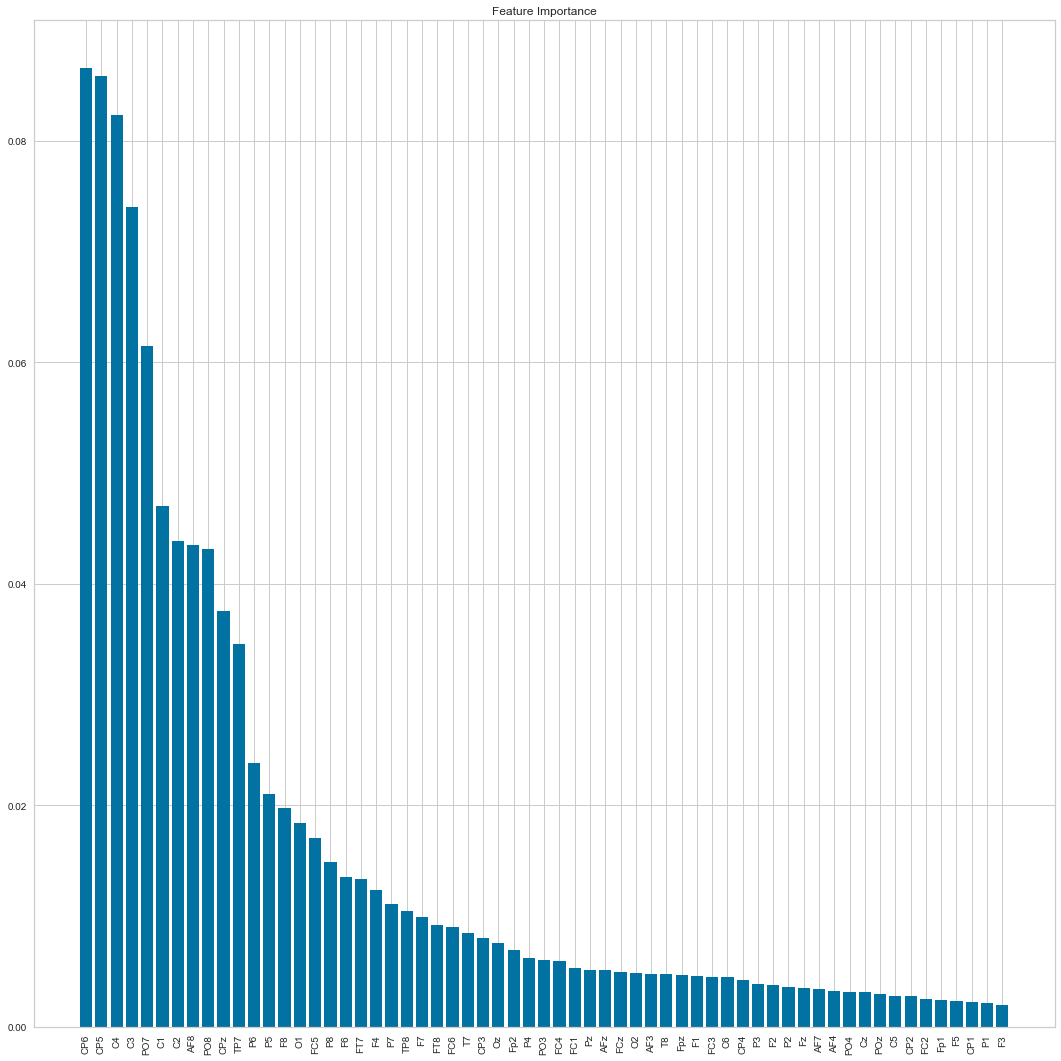

In [390]:
importances = clf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots(figsize=(15,15))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

<h2>Pycaret</h2>

In [391]:
from pycaret.classification import *

clf = setup(data=df_perm_ent.iloc[:,3:], target='subject_identifier', normalize=True)

,Description,Value
0,session_id,8906
1,Target,subject_identifier
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(468, 62)"
5,Missing Values,False
6,Numeric Features,61
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [392]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9666,0.9963,0.9706,0.9655,0.9675,0.9331,0.9342,0.0200
et,Extra Trees Classifier,0.9663,0.9947,0.9882,0.9511,0.9687,0.9322,0.9344,0.0460
rf,Random Forest Classifier,0.9572,0.9943,0.9647,0.9536,0.9588,0.9143,0.9150,0.0550
gbc,Gradient Boosting Classifier,0.9419,0.9890,0.9471,0.9435,0.9439,0.8836,0.8864,0.0470
xgboost,Extreme Gradient Boosting,0.9357,0.9943,0.9353,0.9434,0.9379,0.8711,0.8738,0.0410
qda,Quadratic Discriminant Analysis,0.9355,0.9821,0.9412,0.9374,0.9377,0.8709,0.8739,0.0080
ada,Ada Boost Classifier,0.9328,0.9815,0.9294,0.9435,0.9339,0.8656,0.8706,0.0260
knn,K Neighbors Classifier,0.9325,0.9878,0.9353,0.9379,0.9354,0.8647,0.8672,0.0110
dt,Decision Tree Classifier,0.8932,0.8935,0.8824,0.9135,0.8946,0.7863,0.7922,0.0050
lr,Logistic Regression,0.8894,0.9606,0.8824,0.9048,0.8911,0.7790,0.7829,0.0080


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=8906, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [395]:
perm_ent_lgbm = create_model('lightgbm', fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9545,0.9917,0.9706,0.9429,0.9565,0.9089,0.9093
1,0.9697,0.9991,1.0000,0.9444,0.9714,0.9392,0.9410
2,0.9692,0.9972,0.9706,0.9706,0.9706,0.9383,0.9383
3,0.9385,0.9934,0.9412,0.9412,0.9412,0.8767,0.8767
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
Mean,0.9664,0.9963,0.9765,0.9598,0.9679,0.9326,0.9331
Std,0.0203,0.0032,0.0220,0.0228,0.0195,0.0408,0.0408


In [397]:
perm_ent_lgbm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=8906, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

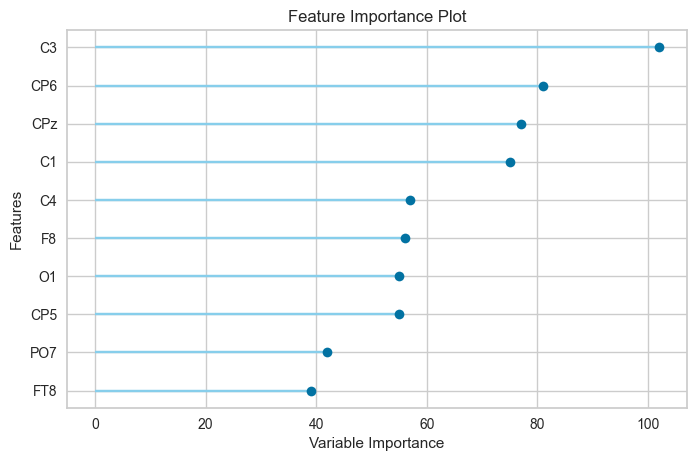

In [398]:
plot_model(perm_ent_lgbm, plot='feature')

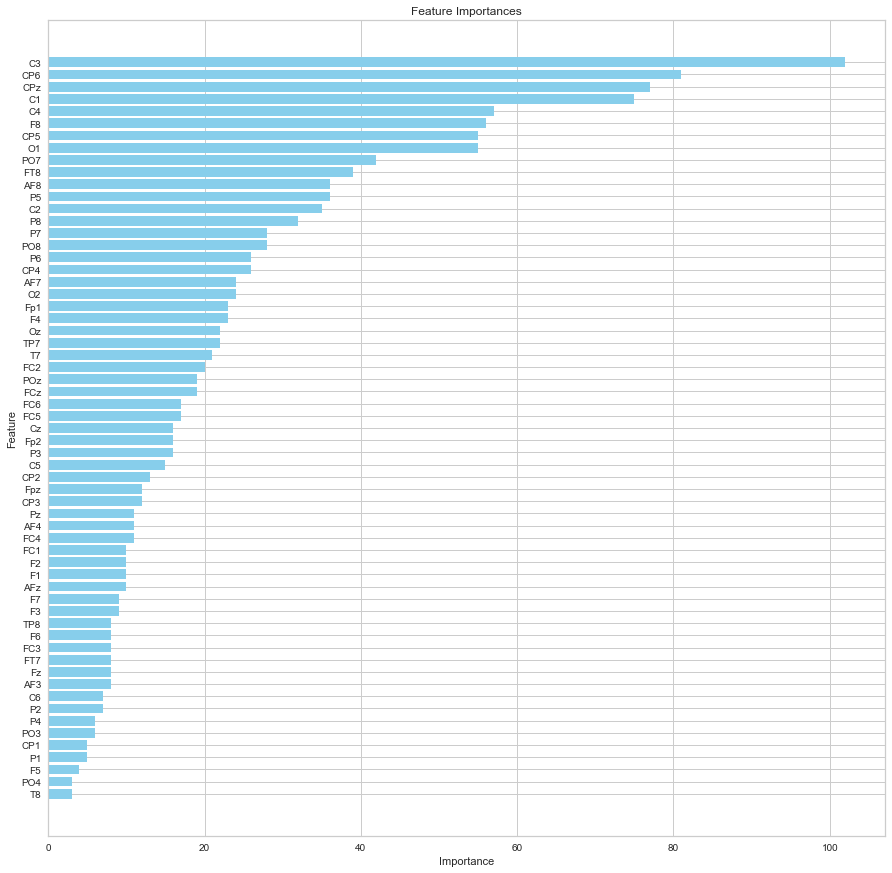

In [400]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = perm_ent_lgbm.feature_importances_

# Create a DataFrame to hold feature names and their importance values
importances_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

# Sort the DataFrame by importance in descending order
importances_df = importances_df.sort_values('importance', ascending=True)

# Plot
plt.figure(figsize=(15, 15))  # Adjust as needed
plt.barh(importances_df['feature'], importances_df['importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()


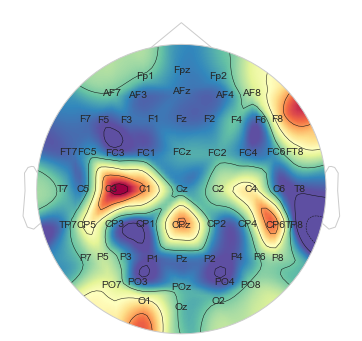

(<matplotlib.image.AxesImage at 0x1eb545798e0>,
 <matplotlib.contour.QuadContourSet at 0x1eb54588fd0>)

In [401]:
from matplotlib.colors import TwoSlopeNorm
plt.rcParams.update({'font.size': 15})  # or whatever size you want
cnorm = TwoSlopeNorm(vmin=min(importances), vcenter=(min(importances) + max(importances))/2, vmax=max(importances))
mne.viz.plot_topomap(data=importances, pos=raw.info, names=X_train.columns, show_names=True, cnorm=cnorm, cmap='Spectral_r')

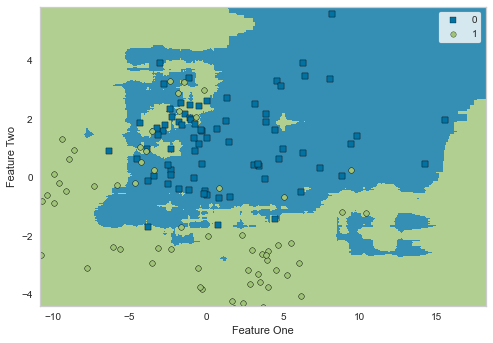

In [404]:
plot_model(hig_et, plot='boundary')


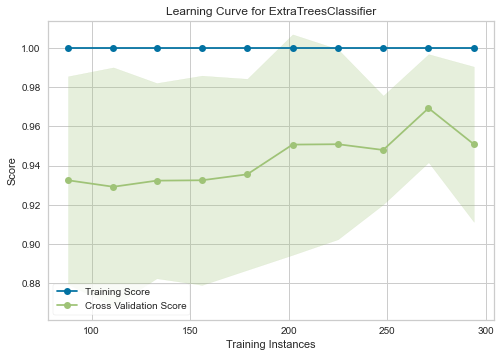

In [405]:
plot_model(hig_et, plot='learning')


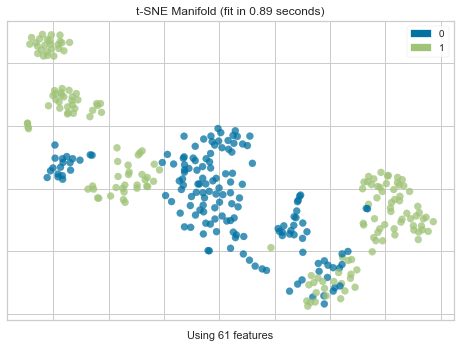

In [406]:
plot_model(hig_et, plot='manifold')

In [407]:
predictions = predict_model(hig_qda, data=pd.concat([X_test, y_test], axis=1))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Quadratic Discriminant Analysis,0.7872,0.8361,0.9574,0.7143,0.8182,0.5745,0.6110


In [408]:
predictions

,AF3,AF4,AF7,AF8,AFz,C1,C2,C3,C4,C5,...,PO8,POz,Pz,T7,T8,TP7,TP8,subject_identifier,Label,Score
48,0.742950,0.730440,0.796018,0.827139,0.731670,0.674463,0.626046,0.731787,0.713572,0.724027,...,0.764584,0.748971,0.736146,0.722576,0.719705,0.745246,0.740926,1,1,1.0000
355,0.711628,0.694248,0.785928,0.726209,0.710718,0.721898,0.760586,0.902026,0.906254,0.703147,...,0.712374,0.692334,0.723876,0.745993,0.759692,0.700071,0.704248,0,1,1.0000
85,0.754276,0.757260,0.769642,0.838722,0.738061,0.756066,0.774502,0.980473,0.977862,0.763206,...,0.824843,0.785928,0.772724,0.768567,0.824169,0.816810,0.788357,1,1,1.0000
34,0.775376,0.851581,0.805889,0.836232,0.793542,0.984203,0.988011,0.985715,0.990004,0.834082,...,0.997962,0.744969,0.762449,0.812492,0.824843,0.816844,0.777012,1,1,1.0000
11,0.694668,0.688509,0.740489,0.688707,0.698425,0.695454,0.673577,0.731475,0.742982,0.749426,...,0.744514,0.713999,0.668233,0.694061,0.737619,0.724575,0.702681,1,0,0.9292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,0.776651,0.800216,0.794039,0.834701,0.760637,0.976902,0.979082,0.996992,0.998315,0.799883,...,0.987231,0.779764,0.757645,0.836085,0.809342,0.794467,0.819592,1,1,1.0000
419,0.725375,0.748303,0.794765,0.805631,0.730610,0.984788,0.985642,0.989252,0.976787,0.788672,...,0.995641,0.758077,0.700989,0.739182,0.720907,0.792568,0.804953,1,1,1.0000
336,0.750059,0.785829,0.796602,0.769141,0.761483,0.981386,0.984265,0.881200,0.893887,0.789602,...,0.994468,0.810933,0.782952,0.772956,0.756501,0.736581,0.733188,0,0,0.9798
414,0.774001,0.782162,0.826070,0.832695,0.771905,0.970223,0.987822,0.991499,0.982504,0.774656,...,0.996644,0.762102,0.724561,0.765065,0.731963,0.760084,0.745803,1,1,1.0000


In [409]:
# import classification report and confusion matrix from sklearn library
from sklearn.metrics import classification_report, confusion_matrix

# create a function to plot confusion matrix and classification report
def plot_cm_cr(model):
    # create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    # plot confusion matrix on 1st subplot
    sns.heatmap(confusion_matrix(predictions['subject_identifier'], predictions['Label']), annot=True, fmt='d', ax=ax[0])
    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('Predicted Label')
    ax[0].set_ylabel('True Label')
    
    # plot classification report on 2nd subplot
    sns.heatmap(pd.DataFrame(classification_report(predictions['subject_identifier'], predictions['Label'], output_dict=True)).iloc[:-1, :].T, annot=True, ax=ax[1])
    ax[1].set_title('Classification Report')
    ax[1].set_xlabel('Metrics')
    ax[1].set_ylabel('Classes')

    print(classification_report(predictions['subject_identifier'], predictions['Label']))

              precision    recall  f1-score   support

           0       0.94      0.62      0.74        47
           1       0.71      0.96      0.82        47

    accuracy                           0.79        94
   macro avg       0.82      0.79      0.78        94
weighted avg       0.82      0.79      0.78        94



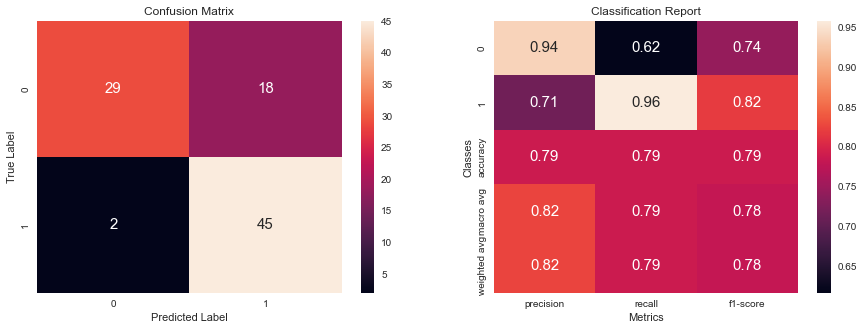

In [410]:
plot_cm_cr(hig_qda)